# A Pairs Trading strategy boosted with AI

This notebook explores a pairs trading strategy fueled by AI innovative techniques. This projected is being developed as part of a master thesis for the degree of Electrical and Computer Engineering.

## Dependencies

This notebook requires code from:
    
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_Trader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

As a good practise, the notebook solely intends to exemplify the application of different trading strategies for different dataset examples, rather than coding the strategies theirselves. Please look into the files menitoned above for more detailed info on how the functions are built.

## Table of Contents
    
    1. Commodity ETFs - entire workflow application example

### Import Libraries

In [162]:
import numpy as np
import pandas as pd

import json

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Import Datetime and the Pandas DataReader
from datetime import datetime
from pandas_datareader import data, wb

# Import alpha vantage
from alpha_vantage.timeseries import TimeSeries

# Import scikit instruments
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

# just set the seed for the random number generator
np.random.seed(107)

In [163]:
ts = TimeSeries(key='MM44549W9ALMWMU0', output_format='pandas')

### Import Configurations

In [164]:
with open('config.json', 'r') as f:
    config = json.load(f)

### Import Classes

In [165]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
series_analyzer = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor(path=config['dataset']['path'])

# 1. Commodity ETFs Dataset

In this section, we proceed to analyze ETFs from different commodity sectors and detect possible interesting pairs. The process goes as follows:

- Upload time series corresponding to ETFs
- Apply dimensionality reduction and cluster securities
- Run cointegration tests for securities within the same cluster

In [6]:
etfs, etfs_unique, tickers = data_processor.read_ticker_excel(ticker_attribute=config['dataset']['ticker_attribute'])

In [7]:
duplicated_etfs = etfs[etfs.duplicated(subset=['Ticker'], keep=False)].sort_values(['Ticker'])
duplicated_etfs

,Sector,Ticker,Description,Issuer,AUM,ExpenseRatio,3-MO TR,Segment
59,Commodity,AAAU,Perth Mint Physical Gold ETF,Exchange Traded Concepts,$108.72M,0.18%,4.10%,Commodities: Precious Metals Gold
339,Precious Metals,AAAU,Perth Mint Physical Gold ETF,Exchange Traded Concepts,$108.72M,0.18%,4.10%,Commodities: Precious Metals Gold
232,Gold,AAAU,Perth Mint Physical Gold ETF,Exchange Traded Concepts,$108.72M,0.18%,4.10%,Commodities: Precious Metals Gold
137,Commodity,AGF,DB Agriculture Long ETN,Deutsche Bank,$716.83K,0.75%,NaN,Commodities: Agriculture
17,Agriculture,AGF,DB Agriculture Long ETN,Deutsche Bank,$716.83K,0.75%,NaN,Commodities: Agriculture
48,Commodity,AGQ,ProShares Ultra Silver,ProShares,$183.61M,5.28%,7.49%,Leveraged Commodities: Precious Metals Silver
362,Silver,AGQ,ProShares Ultra Silver,ProShares,$183.61M,5.28%,7.49%,Leveraged Commodities: Precious Metals Silver
334,Precious Metals,AGQ,ProShares Ultra Silver,ProShares,$183.61M,5.28%,7.49%,Leveraged Commodities: Precious Metals Silver
102,Commodity,BAL,iPath Series B Bloomberg Cotton Subindex Total...,Barclays Bank PLC,$8.84M,0.45%,5.30%,Commodities: Agriculture Cotton
152,Cotton,BAL,iPath Series B Bloomberg Cotton Subindex Total...,Barclays Bank PLC,$8.84M,0.45%,5.30%,Commodities: Agriculture Cotton


In [8]:
etfs_unique.Segment.value_counts()

Equity: U.S. MLPs                                            25
Commodities: Broad Market                                    21
Commodities: Precious Metals Gold                            12
Equity: U.S. Energy                                          11
Commodities: Energy Crude Oil                                10
Equity: Global Gold Miners                                    7
Commodities: Agriculture                                      7
Inverse Commodities: Energy Crude Oil                         7
Equity: Global Metals & Mining                                5
Commodities: Precious Metals Silver                           5
Equity: Global Water                                          5
Leveraged Commodities: Energy Crude Oil                       5
Commodities: Energy                                           4
Inverse Commodities: Precious Metals Gold                     4
Equity: U.S. Oil & Gas Exploration & Production               3
Inverse Equity: U.S. Energy             

In [9]:
dataset = data_processor.read_tickers_prices(tickers=tickers,
                                             initial_date=config['dataset']['initial_date'],
                                             final_date=config['dataset']['final_date'],
                                             data_source=config['dataset']['data_source']
                                            )

Not Possible to retrieve information for AAAU
Not Possible to retrieve information for BATT
Not Possible to retrieve information for CMDY
Not Possible to retrieve information for GLDM
Not Possible to retrieve information for IAUF
Not Possible to retrieve information for PLTM
Not Possible to retrieve information for PYPE
Not Possible to retrieve information for SDCI
Not Possible to retrieve information for XLEY

Unable to download 4.147465437788019% of the ETFs


In [10]:
data_alpha, meta_data = ts.get_daily(symbol='TBLU', outputsize='full')

In [11]:
data_alpha.head(1)

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2017-02-15,25.02,25.159,25.02,25.145,3306.0


Further analyzing the tickers that were not possible to obtain, we cocnlude that many of the considered ETFs are fairly recent and were not available the the initial date defined previously.

## PCA on returns

A purely fundamental approach is a one way to search for pairs, however breadth will likely be low. Sharpe can be maximized by having high breadth (high number of bets). With N stocks in the universe, there are N*(N-1)/2 pair-wise relationships. However, if we do a brute-force search over these, we will likely end up with many spurious results due to comparison bias. As such, we narrow down the search space in a reasonable way, assuming ETFs that share loadings to common factors (defined below) in the past should be related in the future.

In [12]:
etfs_pricing_with_null, etfs_pricing = data_processor.dict_to_df(dataset,
                                                                 config['dataset']['nan_threshold'])
print(etfs_pricing_with_null.shape)
print(etfs_pricing.shape)

From now on, we are only considering 191 ETFs
(248, 208)
(248, 191)


**Remove ETFs without sufficient information**

In [13]:
null_values = etfs_pricing_with_null.isnull().sum()
null_values = null_values[null_values > 0]
null_values

AOIL    245
BAR     165
BCD      58
BCI      58
BMLP      9
COMB    124
COMG     96
GLDW     17
GOAU    120
OILD     54
OILU     54
PPLN    180
TBLU     27
USAI    236
USOD    128
USOI    117
USOU    128
dtype: int64

In [14]:
etfs_returns = data_processor.get_return_series(etfs_pricing)
etfs_returns.head()

,AGF,AGQ,AMJ,AMJL,AMLP,AMU,AMUB,AMZA,ATMP,BAL,...,WTID,WTIU,XES,XLE,XME,XOP,YMLI,YMLP,ZMLP,ZSL
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-09,0.000855,0.010483,-0.010510,0.028561,-0.005464,-0.010340,0.0,-0.009083,-0.012018,-0.016175,...,0.082231,-0.101370,-0.015177,-0.014495,-0.013522,-0.028011,-0.014259,-0.010097,-0.011801,-0.011373
2017-01-10,0.000000,0.027666,-0.014683,-0.023801,-0.008634,-0.014428,0.0,-0.009166,-0.017198,0.002497,...,0.086292,-0.041376,-0.012843,-0.009092,0.035384,0.000000,-0.013836,-0.000756,-0.009346,-0.025814
2017-01-11,0.000000,-0.007011,0.011097,0.000074,0.008709,0.014134,0.0,0.006938,0.010670,0.000623,...,-0.101933,0.054521,0.022550,0.010795,0.003079,0.009852,0.017219,0.012476,0.014675,0.006336
2017-01-12,0.000000,0.004518,-0.004390,0.000000,-0.003140,-0.005973,0.0,-0.001378,-0.003378,-0.011826,...,0.000000,0.048686,-0.010602,-0.004138,-0.013505,-0.006829,-0.003135,-0.001120,-0.004132,-0.005152
2017-01-13,0.000000,0.003374,0.005669,0.000000,0.003937,0.005508,0.0,0.000920,0.002119,-0.000420,...,0.015656,-0.032046,-0.013716,-0.002949,0.008712,-0.006139,0.005031,0.004860,0.005187,-0.002877


In [15]:
print('Total number of possible pairs: ', len(etfs_returns.columns)*(len(etfs_returns.columns)-1)/2)

Total number of possible pairs:  18145.0


**Applying PCA on Returns**

- Protecting from `Curse of Dimensionality` - *source: https://stats.stackexchange.com/questions/232500/how-do-i-know-my-k-means-clustering-algorithm-is-suffering-from-the-curse-of-dim*: Perform a principle components analysis (PCA) and look at how the eigenvalues drop off. It is quite common that most of the variation exists in a couple of dimensions (which typically cut across the original dimensions of your dataset)

To analyze how many principal components we should be using, and accounting for the fact that too many features might incur curse of dimensionality, we proceed to visualize the explanatory power of the first 20 features. We observe that most of the information is in fact contained within the first features. We choose to keep the first 14.

In [65]:
# this show us the feature importance of the 
N_PRIN_COMPONENTS = 20
_, explained_variance = series_analyzer.apply_PCA(N_PRIN_COMPONENTS, etfs_returns)
print(explained_variance)

New shape:  (191, 20)
[1.21088968e+02 5.54566925e+00 2.77277364e-02 1.76371473e-02
 1.04746626e-02 9.37426097e-03 4.28486906e-03 2.83260895e-03
 2.61421070e-03 2.31666273e-03 1.89433208e-03 1.40105490e-03
 1.16798794e-03 1.10482388e-03 9.56219110e-04 8.35893886e-04
 7.46426356e-04 6.23832362e-04 5.79017560e-04 5.54378602e-04]


In [83]:
N_PRIN_COMPONENTS = 14
X, explained_variance = series_analyzer.apply_PCA(N_PRIN_COMPONENTS, etfs_returns)

New shape:  (191, 14)


**Clustering**

We will make use of the DBSCAN unsupervised clustering algorithm, which is available in scikit-learn. DBSCAN has advantages in this use case, specifically:

- DBSCAN does not cluster all stocks; it leaves out stocks which do not neatly fit into a cluster;
- No need to specify the number of clusters.

The clustering algorithm will give us sensible candidate pairs. We will need to do some validation in the next step.

In [84]:
clustered_series_all, clustered_series, counts, clf = series_analyzer.apply_DBSCAN(config['clustering']['epsilon'],
                                                                                   config['clustering']['min_samples'],
                                                                                   X,
                                                                                   etfs_returns)

DBSCAN(algorithm='auto', eps=0.4, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=2, n_jobs=1, p=None)

Clusters discovered: 12
Pairs to evaluate: 389


The epslon parameter strongly dependens on the data. Because of the that, it is not obvious wether DBSCAN is the best algo.

In [85]:
print(counts)

8     17
0     15
1     12
5      8
4      7
2      6
6      4
3      4
9      3
11     2
10     2
7      2
dtype: int64


### Optimize according to Silhouette

When performing PCA, use number of components that maximizes the silhouette coefficient after clustering.

In [170]:
X, clustered_series_all, clustered_series, counts, clf = series_analyzer.clustering_for_optimal_PCA(10,
                                                                                  20,
                                                                                  etfs_returns,
                                                                                  config['clustering'])


Number of components:  10
Clusters discovered: 8
Pairs to evaluate: 6242
Silhouette score  -0.09190494034710367

Number of components:  11
Clusters discovered: 11
Pairs to evaluate: 2311
Silhouette score  -0.087794142155243

Number of components:  12
Clusters discovered: 11
Pairs to evaluate: 1699
Silhouette score  -0.05749697416776681

Number of components:  13
Clusters discovered: 13
Pairs to evaluate: 614
Silhouette score  -0.047647991247087386

Number of components:  14
Clusters discovered: 12
Pairs to evaluate: 389
Silhouette score  -0.06565126098307376

Number of components:  15
Clusters discovered: 14
Pairs to evaluate: 247
Silhouette score  -0.11094323819441472

Number of components:  16
Clusters discovered: 18
Pairs to evaluate: 137
Silhouette score  -0.15122638755581627

Number of components:  17
Clusters discovered: 19
Pairs to evaluate: 120
Silhouette score  -0.1626117624232076

Number of components:  18
Clusters discovered: 18
Pairs to evaluate: 82
Silhouette score  -0.20

**Fundamental analysis for clusters**

In [127]:
for label_n in range(len(counts)):
    elements_cluster_n = list(clustered_series[clustered_series == label_n].index)
    etfs_cluster_n = etfs_unique[etfs_unique['Ticker'].isin(elements_cluster_n)]
    print('\nCluster {}:\n{}'.format(label_n, etfs_cluster_n[['Ticker', 'Segment']]))


Cluster 0:
    Ticker                                            Segment
156    AMJ                                  Equity: U.S. MLPs
154   AMLP                                  Equity: U.S. MLPs
170    AMU                                  Equity: U.S. MLPs
166   AMZA                                  Equity: U.S. MLPs
167   ATMP                                  Equity: U.S. MLPs
179    DIG                      Leveraged Equity: U.S. Energy
157   EMLP                                  Equity: U.S. MLPs
181   ENFR                                  Equity: U.S. MLPs
177    FCG                           Equity: U.S. Natural Gas
165   FENY                                Equity: U.S. Energy
185   FILL  Equity: Global Oil & Gas Exploration & Production
195   FRAK                           Equity: Global Oil & Gas
204   FTXN                             Equity: U.S. Oil & Gas
175    FXN                                Equity: U.S. Energy
171    IEO    Equity: U.S. Oil & Gas Exploration & Product

**Visualizing with t-sne**

In [114]:
def plot_TSNE(X, clf, clustered_series_all):
    """
    This function makes use of t-sne to visualize clusters in 2d.
    """
    X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X) 
    
    # visualization
    plt.figure(1, facecolor='white', figsize=(15,5))
    plt.clf()
    plt.axis('off')

    labels = clf.labels_
    plt.scatter(
        X_tsne[(labels!=-1), 0],
        X_tsne[(labels!=-1), 1],
        s=100,
        alpha=0.85,
        c=labels[labels!=-1],
        cmap=cm.Paired
    )

    plt.scatter(
        X_tsne[(clustered_series_all==-1).values, 0],
        X_tsne[(clustered_series_all==-1).values, 1],
        s=100,
        alpha=0.10
    )

    plt.title('T-SNE of all ETFs with DBSCAN Clusters Noted');

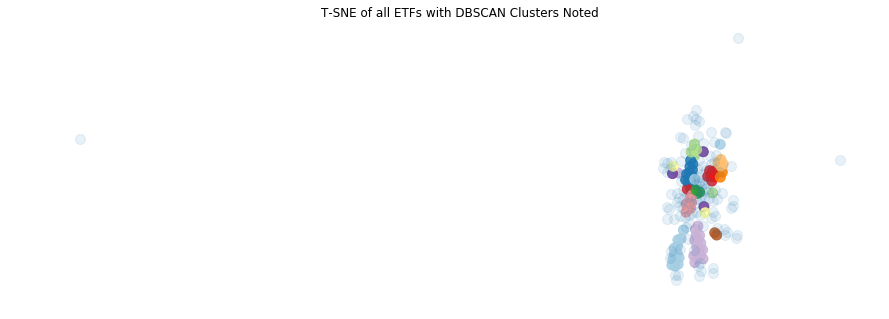

In [115]:
plot_TSNE(X,clf, clustered_series_all)

What can we conclude??
- First of all, the securities in each cluster are indeed from segments tham seem to be fundamentally related.
- Moreover, we see that some filtering is being performed, and the clustering goes further than a simple groupby segment would.

Let's proceed to plot the identified time series.

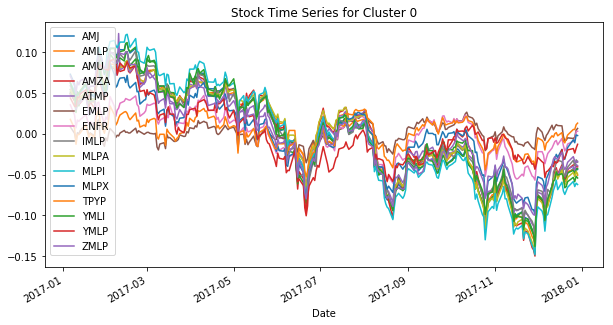

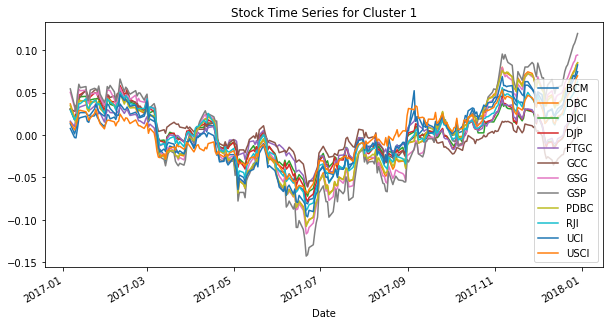

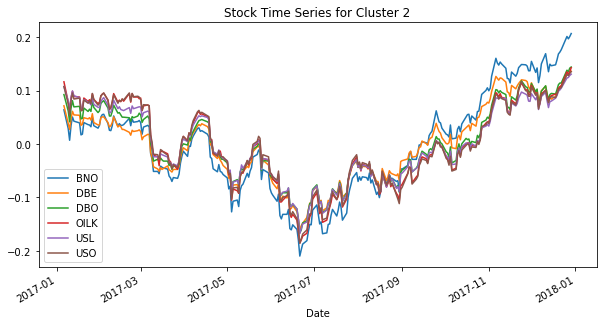

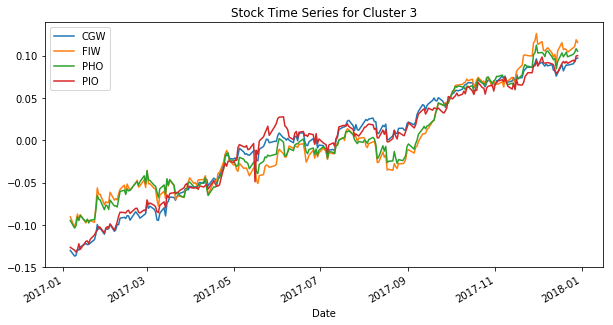

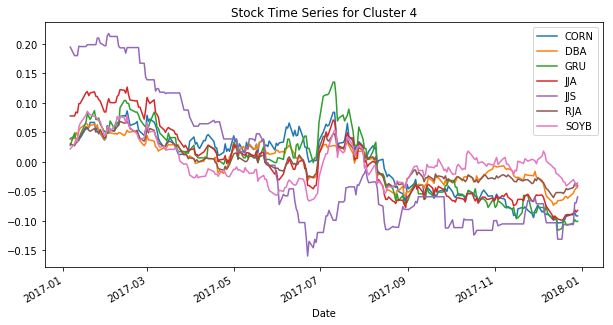

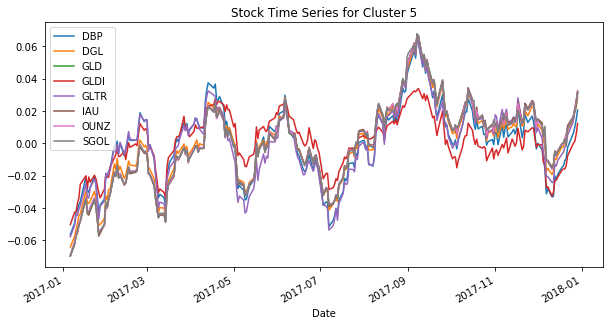

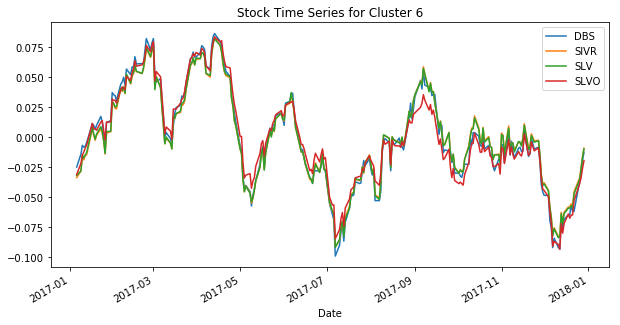

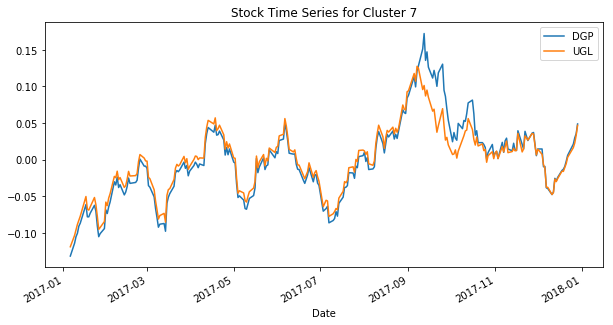

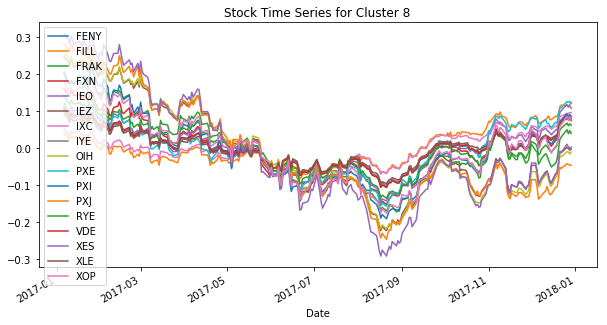

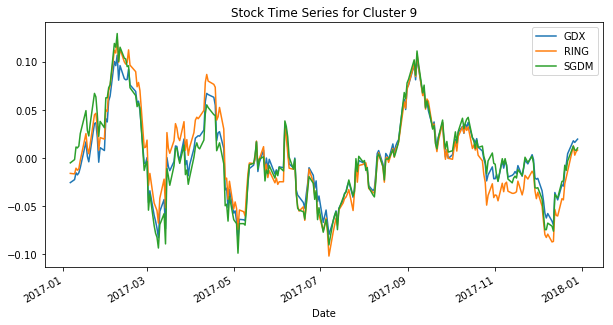

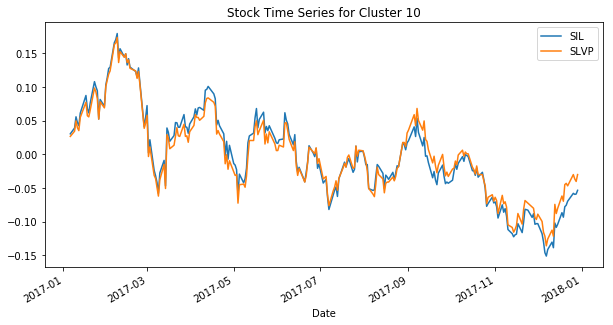

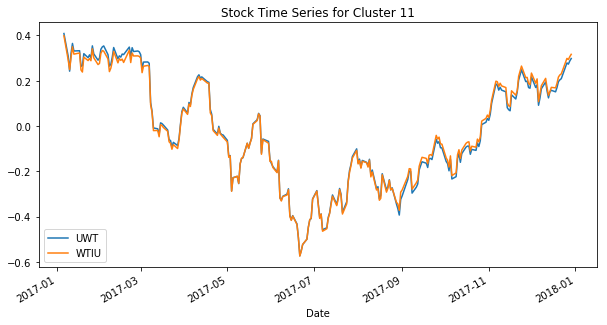

In [116]:
for clust in range(len(counts)):
    symbols = list(clustered_series[clustered_series==clust].index)
    means = np.log(etfs_pricing[symbols].mean())
    series = np.log(etfs_pricing[symbols]).sub(means)
    series.plot(title='Stock Time Series for Cluster %d' % clust, figsize=(10,5))

We now investigate whether it is possible to find cointegrated pairs within the clusters

In [117]:
total_pairs, unique_tickers = series_analyzer.get_candidate_pairs(clustered_series=clustered_series,
                                                            pricing_df=etfs_pricing,
                                                            n_clusters=len(counts),
                                                            min_half_life=config['pair_restrictions']['min_half_life'],
                                                            min_zero_crosings=config['pair_restrictions']['min_zero_crossings'],
                                                            p_value_threshold=config['pair_restrictions']['p_value_threshold'],
                                                            hurst_threshold=config['pair_restrictions']['hurst_threshold']
                                                            )

Found 72 pairs
The pairs contain 45 unique tickers


**Applying Bollinger Bands**

In [118]:
with open('config.json', 'r') as f:
    config = json.load(f)

lookback_multiplier= config['trading']['lookback_multiplier']
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']
# obtain trading filter info
if config['trading_filter']['active'] == 1:
    trading_filter = config['trading_filter']
else:
    trading_filter = None

sharpe_results_bollinger, cum_returns_bollinger, performance_bollinger = trader.apply_bollinger_strategy(total_pairs,
                                                                                         lookback_multiplier,
                                                                                         entry_multiplier,
                                                                                         exit_multiplier,
                                                                                         trading_filter
                                                                                         )



AMJ,AMZA
APR 0.049183664232853586
Sharpe 2.010823468703522


AMJ,EMLP
APR 0.055050442217777995
Sharpe 1.5029144612069532


AMJ,ENFR
APR 0.01667963749745227
Sharpe 0.5092860830071262


AMJ,MLPX
APR -0.003074932033628408
Sharpe -0.09544627562131566


AMJ,TPYP
APR 0.06995897917775329
Sharpe 1.718023749491488


AMLP,EMLP
APR 0.07169972459556417
Sharpe 1.7436436654864487


AMLP,ENFR
APR 0.0020845534357589734
Sharpe 0.07634540792711661


AMLP,MLPI
APR -0.004015032462683421
Sharpe -0.19908146946992467


AMLP,TPYP
APR 0.04101901387563389
Sharpe 1.0407431121675492


AMLP,YMLI
APR 0.03700420926292636
Sharpe 1.0798628868187707


AMU,AMZA
APR 0.03262711348695224
Sharpe 1.3086227127522638


AMU,EMLP
APR 0.052600379372913064
Sharpe 1.4160403722140054


AMU,ENFR
APR 0.012423408503091427
Sharpe 0.37686729977748634


AMU,MLPX
APR 0.003627612946115466
Sharpe 0.13257592877542068


AMU,TPYP
APR 0.04543072986929464
Sharpe 1.1323048190878022


AMZA,EMLP
APR 0.06979152653108955
Sharpe 1.7051563062334458




APR 0.0510539568603956
Sharpe 1.665093372093074


PXE,XLE
APR 0.08812778706107594
Sharpe 2.4046982986666974


PXI,RYE
APR 0.009368690353270592
Sharpe 0.30325804855388405


PXI,XOP
APR 0.017719693652556545
Sharpe 0.7171879136829905


RYE,XOP
APR -0.00019115277604597747
Sharpe 0.009153855644337294


GDX,SGDM
APR 0.013549089639733225
Sharpe 0.4665301157596352


**Bollinger Bands Performance**

Sharpe Ratio Results: 
Average result:  0.8368889157335083


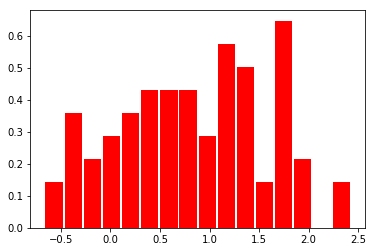

In [119]:
print('Sharpe Ratio Results: ')
n, bins, patches = plt.hist(sharpe_results_bollinger, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average result: ', np.mean(sharpe_results_bollinger))

In [28]:
print('ROI: ', np.mean(cum_returns_bollinger))

ROI:  3.106457560443754


**Applying the Kalman filter based strategy**

In [29]:
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']

sharpe_results_kalman, cum_returns_kalman, performance_kalman = trader.apply_kalman_strategy(total_pairs, 
                                                                         entry_multiplier,
                                                                         exit_multiplier)



AMJ,AMZA
APR 0.008609155207923713
Sharpe 0.8836844232180374


AMJ,EMLP
APR 0.019149806712715822
Sharpe 0.7625274791039464


AMJ,ENFR
APR 0.027902019587639826
Sharpe 1.3575391310766787


AMJ,MLPX
APR 0.014914041679716883
Sharpe 1.2306596403745802


AMJ,TPYP
APR 0.010103760486225966
Sharpe 0.6983369381842246


AMLP,EMLP
APR -0.020857757343193506
Sharpe -0.5144220808518788


AMLP,ENFR
APR 0.10924348237845183
Sharpe 2.9099200086942036


AMLP,MLPI
APR 0.004699356498791607
Sharpe 0.5334306693647716


AMLP,TPYP
APR 0.0642667845793905
Sharpe 1.9525027861888882


AMLP,YMLI
APR 0.04838882426943547
Sharpe 2.0225563125497437


AMU,AMZA
APR 0.010408081439410966
Sharpe 1.0287523863825085


AMU,EMLP
APR -0.017436864358916893
Sharpe -0.48132063391879953


AMU,ENFR
APR 0.07286080781714421
Sharpe 2.697225141248975


AMU,MLPX
APR 0.020972122606757404
Sharpe 1.5450650356827322


AMU,TPYP
APR 0.0012171776384770627
Sharpe 0.058257147357612005


AMZA,EMLP
APR -0.018298766802062216
Sharpe -0.276292332304818

Sharpe Ratio Results: 
Average result:  1.257137772641425


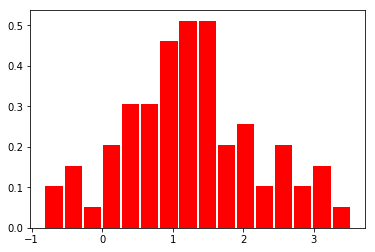

In [30]:
print('Sharpe Ratio Results: ')
n, bins, patches = plt.hist(sharpe_results_kalman, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average result: ', np.mean(sharpe_results_kalman))

In [31]:
print('ROI: ', np.mean(cum_returns_kalman))

ROI:  3.4345751439383605


## Get some insight on the strategies

Let's start by analyzing the strategies with negative results:

In [526]:
failed_pairs[1][0][:2]

('AMLP', 'MLPI')

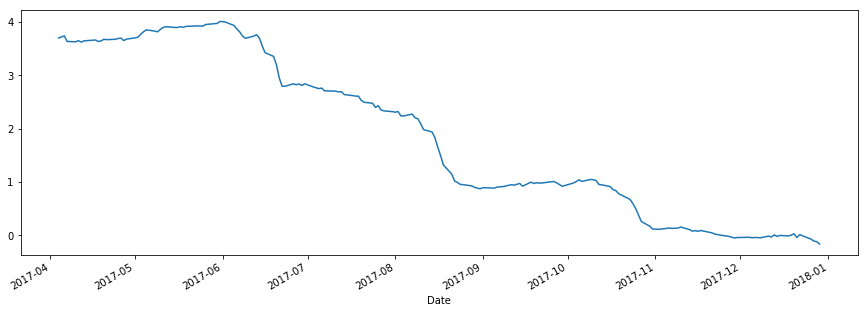

In [527]:
# pick random pair
failed_pairs[1][1]['spread'].plot(figsize=(15,5))

In [528]:
# percentage of time with position opened
len(failed_pairs[1][1][failed_pairs[1][1].units != 0])/len(failed_pairs[1][1])*100

60.84905660377359

In [529]:
failed_pairs[1][1].to_excel('./data/failed_pair.xlsx')

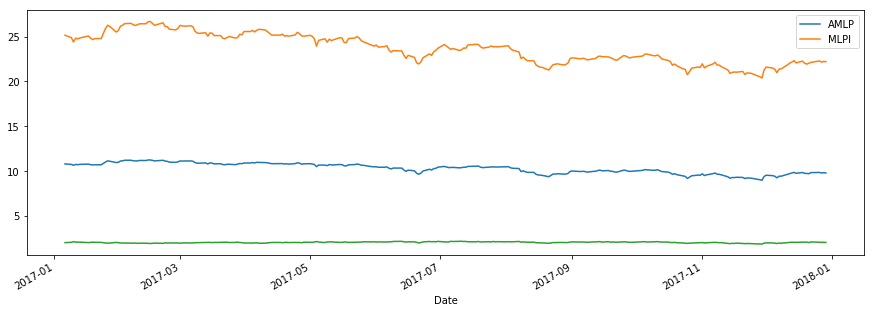

In [531]:
etfs_pricing[[item for item in failed_pairs[1][0][:2]]].plot(figsize=(15,5))
#failed_pairs[1][1].spread.plot()
#failed_pairs[1][1].zscore.plot()
failed_pairs[1][0][2]['spread'].plot()
#plt.axhline(failed_pairs[1][0][2]['spread'].mean(), linestyle='--')
#plt.axhline(failed_pairs[1][0][2]['spread'].mean()+failed_pairs[1][0][2]['spread'].std(), linestyle='--')

## Some remarks

- From the analysis above, the Kalman filter method obtains the best performance, with an average Sharpe Ratio larger than 1.
- Different time periods should be tested, to provide information on the variability of these results.
- We should compare this approach with a *compare all against all* approach, to see by which factor our results are improved due to the clustering technique.

**All against all** - *comparing against the simplest strategy*

In [79]:
threshold = 0.05
total_pairs_all_a_all = series_analyzer.find_cointegrated_pairs(etfs_pricing, threshold, min_half_life=5)
pairs_found_all_a_all = len(total_pairs_all_a_all)
print('Found {} pairs'.format(pairs_found_all_a_all))

Found 7075 pairs


Bollinger Bands:

In [80]:
lookback_multiplier=2
sharpe_results_bollinger_all_a_all = []
for pair in total_pairs_all_a_all:
    print('\n\n{},{}'.format(pair[0], pair[1]))
    coint_result = pair[2]
    pnl, ret, summary, sharpe = trader.bollinger_band_strategy(coint_result['Y'], coint_result['X'], 
                                                               lookback_multiplier*coint_result['half_life'])
    sharpe_results_bollinger_all_a_all.append(sharpe)



AGF,BAL
APR -0.18458732869625571
Sharpe -0.819163033596973


AGF,BCM
APR -0.23986978739746612
Sharpe -0.6525034576399714


AGF,BOS
APR -0.475358819959371
Sharpe -2.1516560273498317


AGF,COPX
APR 0.32495511493915163
Sharpe 0.864643943563558


AGF,DBP
APR 0.15223299171903837
Sharpe 1.5943754263288679


AGF,DDG
APR -0.0588167229160127
Sharpe -0.03530316171511648


AGF,DDP
APR -0.28464806277213006
Sharpe -1.3221861463689768


AGF,DGAZ
APR -0.015414607649056222
Sharpe 0.2161010265141564


AGF,DGL
APR 0.11344257363102161
Sharpe 1.1013401585117266


AGF,DGZ
APR 0.016286782899732177
Sharpe 0.19570343708728238


AGF,DIG
APR 0.1614312798693407
Sharpe 0.5713666558046285


AGF,DJP
APR -0.4294995079029875
Sharpe -1.365011703593262


AGF,DSLV
APR 0.8443962652325472
Sharpe 2.1124884310057044


AGF,DUST
APR 1.81162523967176
Sharpe 2.34153414042689


AGF,DZZ
APR -0.19819111070550066
Sharpe -1.1465710162324039


AGF,EMLP
APR -0.10787104607587072
Sharpe -0.7884971165742862


AGF,ENFR
APR 0.15048412722

APR -0.057393346214174024
Sharpe -0.38643633813135964


AGQ,DBB
APR 0.030571828554671
Sharpe 0.27096159759566424


AGQ,DDP
APR -0.07715614968662299
Sharpe -0.1319424476328707


AGQ,DGAZ
APR -0.2167308144273592
Sharpe -0.3027458342879398


AGQ,DYY
APR -0.21268417769541015
Sharpe -0.5253016479955575


AGQ,DZZ
APR 0.1258733376209118
Sharpe 1.0964428812743499


AGQ,EMLP
APR -0.006185432154686588
Sharpe -0.031434630432033865


AGQ,ENFR
APR -0.033888330900627484
Sharpe -0.2657356602551555


AGQ,FCG
APR -0.07378232244068506
Sharpe -0.35923465249116127


AGQ,FIW
APR -0.03628790307000829
Sharpe -0.22796980706937903


AGQ,FRAK
APR -0.0697884868489147
Sharpe -0.2933076664708144


AGQ,FUD
APR 0.20281784650600398
Sharpe 1.243480876147125


AGQ,GASL
APR -0.015869115947315438
Sharpe 0.056720027059010504


AGQ,GASX
APR -0.09042849340450676
Sharpe -0.29206878764015165


AGQ,GCC
APR 0.115591670626908
Sharpe 2.0540639699238827


AGQ,GDX
APR 0.19268935454037805
Sharpe 2.0172403507426484


AGQ,GDXJ
APR 0.1

APR -0.04268645527741266
Sharpe -0.11905834563646918


AGQ,UBG
APR 0.13121664095164332
Sharpe 1.7750051933506021


AGQ,UGAZ
APR -0.15436869048426227
Sharpe -0.5414117826466025


AGQ,UNG
APR -0.08916951694509345
Sharpe -0.3445593138341833


AGQ,UNL
APR 0.031047435807395107
Sharpe 0.2621278946784055


AGQ,URA
APR 0.08479207543440914
Sharpe 0.5910707028495454


AGQ,USLV
APR 0.034481269881976084
Sharpe 2.3685947944348715


AGQ,XES
APR -0.2200778187925535
Sharpe -1.1079669192110966


AGQ,XOP
APR 0.15567257913956856
Sharpe 0.8425349661629185


AGQ,YMLI
APR 0.10452966412424813
Sharpe 0.7993023878123995


AGQ,YMLP
APR 0.05436278986339049
Sharpe 0.49698156812802985


AGQ,ZMLP
APR 0.03906729800652964
Sharpe 0.3499906877110273


AMJ,AMUB
APR 0.2018417461447759
Sharpe 1.3890809654269278


AMJ,AMZA
APR 0.049183664232853586
Sharpe 2.010823468703522


AMJ,BOIL
APR -0.06309216942683626
Sharpe -0.3946405760633817


AMJ,BOS
APR -0.05766104263328753
Sharpe -0.19438469561972896


AMJ,CGW
APR -0.0282417524

APR 0.013238982746224703
Sharpe 0.21475391387299259


AMJ,SLVO
APR -0.05547870172368752
Sharpe -0.7198056038760744


AMJ,SLVP
APR 0.1278964363028905
Sharpe 0.9801605475279805


AMJ,TAGS
APR 0.020409281946551783
Sharpe 0.22435501675426725


AMJ,TPYP
APR 0.06995897917775329
Sharpe 1.718023749491488


AMJ,UBG
APR 0.07364028449178228
Sharpe 1.0352241838262524


AMJ,UGAZ
APR 0.18131906149768517
Sharpe 0.680914524238941


AMJ,UGL
APR -0.028447280797460617
Sharpe -0.1837763640421802


AMJ,UGLD
APR -0.10868380717584769
Sharpe -0.6789473260385326


AMJ,USLV
APR -0.07290979245498785
Sharpe -0.48185667746951466


AMJ,USV
APR -0.0451159253957647
Sharpe -0.32894904395946706


AMJ,ZSL
APR -0.21910733284171147
Sharpe -1.59741075305021


AMJL,AMUB
APR 0.11846845055639621
Sharpe 0.6788648692260436


AMJL,BOIL
APR 0.10587630414018578
Sharpe 0.4580717037209821


AMJL,BOS
APR -0.09328720856474715
Sharpe -0.34179938088344125


AMJL,CANE
APR 0.39258914279233315
Sharpe 1.927364977646223


AMJL,CGW
APR 0.1858

APR 0.3494792990627349
Sharpe 1.990707000731253


AMJL,SILJ
APR -0.03031459344020926
Sharpe -0.0469082419415614


AMJL,SIVR
APR -0.08890133262193312
Sharpe -0.8848068724618738


AMJL,SLV
APR -0.08525195030451127
Sharpe -0.8463991408299277


AMJL,SLVO
APR -0.013492188773665648
Sharpe -0.08698773356588023


AMJL,SLVP
APR 0.31509505144884886
Sharpe 1.7000156034267961


AMJL,TAGS
APR -0.016803745120950397
Sharpe -0.0400936462674029


AMJL,TPYP
APR -0.017811910771413864
Sharpe -0.18935164211528863


AMJL,UBG
APR 0.1840728834060832
Sharpe 2.4020392097593377


AMJL,UGAZ
APR 0.3811527006798432
Sharpe 0.9515903398894748


AMJL,UGL
APR -0.04325596792891595
Sharpe -0.22212172249464182


AMJL,UGLD
APR -0.08807698167832512
Sharpe -0.3580387924727402


AMJL,USLV
APR -0.030754611059175097
Sharpe -0.016385362493427164


AMJL,USV
APR -0.16927882957833418
Sharpe -1.1101016113964408


AMJL,ZSL
APR -0.2820303184264591
Sharpe -1.562652110552143


AMLP,AMUB
APR -0.08797763634537215
Sharpe -0.837209536125967

APR -0.12609929176770995
Sharpe -1.0677914330491802


AMLP,RJA
APR 0.08102706637525392
Sharpe 1.1797842186648984


AMLP,SGDM
APR -0.0779199423026472
Sharpe -0.5900636258052148


AMLP,SGOL
APR 0.02299922820698841
Sharpe 0.38108124434284874


AMLP,SIL
APR 0.11762021477454376
Sharpe 0.9165389011828585


AMLP,SIVR
APR -0.013686876937692882
Sharpe -0.13977383248193076


AMLP,SLV
APR -0.006521883821518415
Sharpe -0.04653163367106919


AMLP,SLVO
APR -0.014472212034818632
Sharpe -0.15966481505430832


AMLP,SLVP
APR -0.09603017228914335
Sharpe -0.692913569560071


AMLP,TAGS
APR 0.08234663713748946
Sharpe 0.7239224086087193


AMLP,TPYP
APR 0.04101901387563389
Sharpe 1.0407431121675492


AMLP,UAG
APR -0.01302668742713975
Sharpe -0.018898344816105483


AMLP,UBG
APR 0.0425060789788374
Sharpe 0.6697758417686288


AMLP,UGAZ
APR 0.06424924492981687
Sharpe 0.3566971709493478


AMLP,UGL
APR 0.007032213313990177
Sharpe 0.11971386930426108


AMLP,UGLD
APR 0.0005454843437124879
Sharpe 0.06926067735147437



APR 0.06856358414561337
Sharpe 0.8150251848173362


AMU,RING
APR -0.17679100261234804
Sharpe -1.31892040248481


AMU,RJA
APR 0.10825875040841137
Sharpe 1.5574870124775269


AMU,SGDM
APR -0.06730432921498486
Sharpe -0.47581177005017167


AMU,SGOL
APR -0.0025775546739109645
Sharpe 0.0017364646561316137


AMU,SIL
APR 0.3100404932643217
Sharpe 1.9290424679556495


AMU,SIVR
APR 0.019653779726876763
Sharpe 0.30207927655648964


AMU,SLV
APR 0.01836107936012099
Sharpe 0.28593341683225454


AMU,SLVO
APR -0.09208324567406445
Sharpe -1.2866226758390313


AMU,SLVP
APR 0.19085721355236185
Sharpe 1.3053748192896872


AMU,TAGS
APR -0.11288308475055575
Sharpe -1.2168654708243796


AMU,TPYP
APR 0.04543072986929464
Sharpe 1.1323048190878022


AMU,UBG
APR 0.06303939848884865
Sharpe 0.9001690402963767


AMU,UGAZ
APR 0.2513936363305571
Sharpe 0.8494496118429201


AMU,UGL
APR 0.021037802261332894
Sharpe 0.2465175260496013


AMU,UGLD
APR 0.00011599146473573185
Sharpe 0.07059821396933089


AMU,USLV
APR 0.0543



AMUB,NIB
APR 0.4814720978898974
Sharpe 2.4593097478806


AMUB,NLR
APR 0.17729356051154177
Sharpe 1.5878467066102593


AMUB,NUGT
APR 0.23880221490630427
Sharpe 1.1534104826924823


AMUB,OIH
APR 0.1933691485809359
Sharpe 1.5333737780482293


AMUB,OUNZ
APR 0.10075950774277986
Sharpe 1.4893222291253507


AMUB,PALL
APR -0.20180572125190588
Sharpe -1.6359746171744665


AMUB,PGM
APR 0.09883792898889876
Sharpe 0.7376274903446375


AMUB,PIO
APR 0.024853852811940635
Sharpe 0.3899851188342787


AMUB,PXJ
APR 0.14716396520096353
Sharpe 1.1245215559807353


AMUB,RING
APR 0.13907305867004793
Sharpe 1.120471083788781


AMUB,RJA
APR 0.08564302700684667
Sharpe 0.8630234021153234


AMUB,SGDM
APR 0.23024526266539436
Sharpe 1.9679818030528191


AMUB,SGOL
APR 0.09024122248035993
Sharpe 1.3196760839525479


AMUB,SIL
APR 0.37572261408259267
Sharpe 2.1306867039128186


AMUB,SIVR
APR 0.26782009445502286
Sharpe 2.307305494634545


AMUB,SLV
APR 0.2675221500540914
Sharpe 2.3099354602780964


AMUB,SLVO
APR 0.2620

APR -0.3975848418222494
Sharpe -1.3103384963881854


AMZA,JJA
APR -0.027933503027463558
Sharpe -0.18346651468202912


AMZA,JJC
APR 0.022262174544496638
Sharpe 0.22802625863205733


AMZA,JJG
APR 0.03523872251807969
Sharpe 0.36899789229011615


AMZA,JJP
APR -0.0004360060491656048
Sharpe 0.04627522805935476


AMZA,JJT
APR -0.04254641705611162
Sharpe -0.35046301499230675


AMZA,JO
APR 0.11786953205404416
Sharpe 0.8548214352379508


AMZA,KOLD
APR -0.03415718656963973
Sharpe 0.030302496740340953


AMZA,LIT
APR -0.1084609452998131
Sharpe -0.806158002688392


AMZA,MLPB
APR 0.12191759289725934
Sharpe 0.9237840574214868


AMZA,MLPE
APR -0.09786112164415017
Sharpe -0.6885417454241841


AMZA,MLPI
APR 0.02377406635787027
Sharpe 0.9112443481064796


AMZA,MLPO
APR 0.00301141905217972
Sharpe 0.08329741858263637


AMZA,MLPQ
APR 0.03638436198062167
Sharpe 0.8093681946683867


AMZA,MLPX
APR 0.01279329689727482
Sharpe 0.44332229570199566


AMZA,NIB
APR 0.02121174755813371
Sharpe 0.20572969630358326


AMZA

APR -0.01821519101781277
Sharpe -0.09180800316193496


ATMP,GDX
APR -0.12817160484258583
Sharpe -0.9357993181873216


ATMP,GDXS
APR -0.17641638485515143
Sharpe -0.7542783382545717


ATMP,GDXX
APR -0.23817597532077484
Sharpe -1.0421953665016177


ATMP,GLD
APR 0.03571734045033037
Sharpe 0.5590013922646816


ATMP,GLDI
APR 0.07956184337020078
Sharpe 1.222977814823549


ATMP,GLL
APR 0.0702643284172928
Sharpe 0.631636321886784


ATMP,GLTR
APR 0.05056855154942208
Sharpe 0.7280266154169958


ATMP,GOEX
APR -0.040517711593986094
Sharpe -0.19465790141742942


ATMP,IAU
APR 0.0401012520825863
Sharpe 0.6106251433260523


ATMP,JDST
APR 0.03743091344024818
Sharpe 0.27427485848663546


ATMP,JJA
APR -0.06720544813755525
Sharpe -0.6300654758425619


ATMP,JJG
APR 0.004695377623198382
Sharpe 0.09697477685854479


ATMP,JJP
APR 0.1269923079542432
Sharpe 1.320484988085969


ATMP,JJT
APR -0.08924565139032758
Sharpe -0.8250720197355068


ATMP,JO
APR -0.030551775485547328
Sharpe -0.17733831777463405


ATMP,LIT
A

APR -0.10136795721708047
Sharpe -1.2773607190853502


BAL,JDST
APR 0.01845155261875031
Sharpe 0.21534938530975417


BAL,JJP
APR -0.16331847284958112
Sharpe -1.3549528378205609


BAL,JJT
APR 0.016906693000633854
Sharpe 0.21090873922413808


BAL,NIB
APR -0.079332825307736
Sharpe -0.38620947929026883


BAL,OUNZ
APR -0.07200288367615415
Sharpe -1.0169330947019761


BAL,RYE
APR -0.03789224866497598
Sharpe -0.2512393085363631


BAL,SGDM
APR -0.26860373538379
Sharpe -1.9674697572687383


BAL,SIVR
APR -0.1008193438297087
Sharpe -0.9393317311882374


BAL,SLV
APR -0.10712728671289595
Sharpe -1.0186688515748474


BAL,SZO
APR -0.1406924189686949
Sharpe -0.4870952807851399


BAL,TPYP
APR -0.06315433429309614
Sharpe -0.5983038994862815


BAL,UBG
APR -0.10090877591474956
Sharpe -1.3049406918629185


BAL,UGL
APR -0.28568314376285175
Sharpe -2.680022556396234


BAL,UGLD
APR -0.364217388012713
Sharpe -2.7283584547254636


BAL,XOP
APR -0.16315430097280958
Sharpe -1.0516677955244105


BAL,ZSL
APR -0.28496

APR 0.04443148818491682
Sharpe 0.4688227145747095


BDD,GRU
APR 0.06441780735306879
Sharpe 0.5024990814108558


BDD,JDST
APR -0.2840659983562527
Sharpe -0.6494557278209099


BDD,JJG
APR 0.13994416048821945
Sharpe 0.6924786668125189


BDD,JJN
APR -0.38405228155086846
Sharpe -1.6218203349661366


BDD,JJP
APR 0.01080621697719053
Sharpe 0.14792239574042956


BDD,JJT
APR -0.00599568830008701
Sharpe -0.0004916899922824544


BDD,KOL
APR -0.08229076333383278
Sharpe -0.261791769017872


BDD,KOLD
APR 0.2901194540717169
Sharpe 0.9217209629420617


BDD,MLPB
APR 0.18056896187108418
Sharpe 1.1010070470955695


BDD,MLPO
APR 0.2533433898314621
Sharpe 1.1313006085979282


BDD,NIB
APR -0.28262097641649253
Sharpe -1.2703460198994647


BDD,NUGT
APR 0.14734935716341213
Sharpe 0.5706768639052261


BDD,SGDM
APR 0.00046450204955905683
Sharpe 0.08742321362893432


BDD,SIVR
APR 0.08000085961942638
Sharpe 0.6802386703103698


BDD,SLV
APR 0.06747839200340366
Sharpe 0.5939890426841994


BDD,SLVO
APR 0.034344206994

APR 0.12279455563439723
Sharpe 1.2812866376273906


BOIL,DBS
APR -0.11432634671169684
Sharpe -0.7652058771794007


BOIL,DDP
APR -0.11630828777982427
Sharpe -0.28970402179167776


BOIL,DGAZ
APR 0.22900538237182166
Sharpe 2.0669270325699203


BOIL,DGL
APR 0.12878805922762804
Sharpe 1.4307134913550899


BOIL,DGLD
APR 0.31681393986208906
Sharpe 1.3273423819149928


BOIL,DGP
APR 0.09188853718173018
Sharpe 0.623082475672437


BOIL,DGZ
APR 0.09274038356076164
Sharpe 0.9949520684576122


BOIL,DSLV
APR -0.21789835301118432
Sharpe -0.6108311882731194


BOIL,DUST
APR 0.2598511736267002
Sharpe 0.7381921964099918


BOIL,DZZ
APR 0.07419487012328996
Sharpe 0.45465720707732865


BOIL,EMLP
APR 0.12817069249241553
Sharpe 1.4313337276634568


BOIL,ENFR
APR -0.05265194375499238
Sharpe -0.39125256890787835


BOIL,FIW
APR 0.004851675813875245
Sharpe 0.13074560719532113


BOIL,FUD
APR 0.01318629860754883
Sharpe 0.18172788046869948


BOIL,GDX
APR 0.261415698533068
Sharpe 1.39936753094019


BOIL,GDXS
APR 0.489

APR -0.27942721871702036
Sharpe -0.5221292557738116


BOM,CORN
APR 0.09521818983877406
Sharpe 0.4443954267011371


BOM,CPER
APR -0.2914868220632849
Sharpe -0.8402655485561991


BOM,CRAK
APR -0.5845562445264978
Sharpe -2.345899858125292


BOM,DBA
APR 0.1654338249291072
Sharpe 1.0153657640770963


BOM,DBB
APR 0.22791862438324584
Sharpe 0.7364930400331395


BOM,DBP
APR 0.2688633191414924
Sharpe 1.6710582501886642


BOM,DBS
APR 0.10143344559662149
Sharpe 0.6999957787436976


BOM,DDP
APR 0.038914865635907514
Sharpe 0.27592430407942425


BOM,DGAZ
APR 0.4177411420484818
Sharpe 0.8978304550962898


BOM,DGL
APR 0.22225703317169643
Sharpe 1.4160338786721565


BOM,DGLD
APR 0.30444150150564764
Sharpe 1.1142509541023695


BOM,DGP
APR -0.04137977337509979
Sharpe -0.11884218806768496


BOM,DGZ
APR 0.14971449613341292
Sharpe 0.9643644067900944


BOM,DSLV
APR 0.2447196926920463
Sharpe 0.7726673377172077


BOM,DUST
APR -0.16288884302624718
Sharpe -0.1578090845230322


BOM,DWT
APR -0.38902938118852526
Sh

APR 0.34774022071413624
Sharpe 1.5355256005979125


BOM,UGLD
APR 0.37631448455034144
Sharpe 1.343694004629794


BOM,UNG
APR 0.23790068491806027
Sharpe 0.8500879147059999


BOM,UNL
APR 0.006185329137207152
Sharpe 0.15230169533503937


BOM,USCI
APR -0.12039460283398684
Sharpe -0.1725986710224434


BOM,WEAT
APR 0.2553232318784675
Sharpe 0.8703979117545535


BOM,WTID
APR -0.3511781146162293
Sharpe -0.708245193246902


BOM,XME
APR -0.2670829646997267
Sharpe -0.6124971552801115


BOM,ZSL
APR 0.3320500780324884
Sharpe 1.1057055793968327


BOS,CHIE
APR 0.08332873575500033
Sharpe 0.8093022160942343


BOS,COPX
APR -0.1448659999734122
Sharpe -0.4049551272534815


BOS,CORN
APR -0.33328867026193354
Sharpe -1.670838485156977


BOS,CPER
APR 0.1139902636621637
Sharpe 0.5884531401988906


BOS,DAG
APR -0.3185576219548364
Sharpe -1.4360048369707759


BOS,DBA
APR -0.10903774039615377
Sharpe -0.6360406686941973


BOS,DBB
APR 0.2244445138843576
Sharpe 1.0079930498045238


BOS,DBP
APR 0.14500803084396185
Sha

APR 0.1856234358026545
Sharpe 1.521958458721871


BOS,PALL
APR -0.08081602053359804
Sharpe -0.18395268676811913


BOS,PICK
APR 0.01939277245489457
Sharpe 0.2030438641801662


BOS,PXJ
APR -0.20437783988312197
Sharpe -0.7894745140895858


BOS,RING
APR 0.266009307919731
Sharpe 1.5507135502692448


BOS,RJA
APR -0.25125660370295044
Sharpe -1.371453188997532


BOS,RJZ
APR -0.011069085816027058
Sharpe 0.052759211407286594


BOS,SGDM
APR 0.28699553275194156
Sharpe 1.526250715432267


BOS,SGOL
APR 0.058064441373221864
Sharpe 0.42291416978437013


BOS,SIL
APR 0.22132911449168713
Sharpe 0.9543961142927633


BOS,SILJ
APR 0.36561823190756715
Sharpe 1.3490971102800724


BOS,SIVR
APR -0.2553766717345205
Sharpe -3.2034783494716748


BOS,SLV
APR -0.2508954164732341
Sharpe -3.1204517954123663


BOS,SLVP
APR 0.14407561996172102
Sharpe 0.9588802177604303


BOS,TAGS
APR -0.2864671661262511
Sharpe -1.6664748540493932


BOS,TPYP
APR 0.09064637078185744
Sharpe 0.7382189950706506


BOS,UAG
APR 0.40594713378085

/Users/simaomoraessarmento/Dropbox/IST/Tese/code/PairsTrading/class_Trader.py:170: RuntimeWarning: invalid value encountered in double_scalars
  APR = ((np.prod(1.+ret))**(252./len(ret)))-1


APR nan
Sharpe -0.1508292635085667


CANE,DBP
APR -0.040291604137742576
Sharpe -0.4380716775281002


CANE,DBS
APR -0.03622385950530527
Sharpe -0.23904810649478941


CANE,DDP
APR -0.0390071528158249
Sharpe -0.05342774705018532


CANE,DGAZ
APR 0.15622899607634144
Sharpe 0.5780270466249359


CANE,DGL
APR -0.060817951372844514
Sharpe -0.7726643209637292


CANE,DGLD
APR -0.1542602661202358
Sharpe -0.9165780454418578


CANE,DGP
APR 0.019887756114201238
Sharpe 0.21499010769821145


CANE,DGZ
APR -0.0236756072363995
Sharpe -0.2546053400722056


CANE,DSLV
APR -0.13818891712619097
Sharpe -0.5068547576978871


CANE,DUST
APR -0.3401239639557573
Sharpe -1.2627494267716846


CANE,DZZ
APR 0.15302678084303545
Sharpe 1.027643196447519


CANE,EMLP
APR -0.0497195486281381
Sharpe -0.6912639325389466


CANE,ENFR
APR 0.06208471622709455
Sharpe 0.6578529589844264


CANE,GASL
APR -0.1568862438050217
Sharpe -0.4514625625406159


CANE,GDX
APR -0.10289277982759337
Sharpe -0.6973345945014034


CANE,GDXJ
APR 0.1414

APR -0.01640807362873975
Sharpe -0.21190393991366555


CGW,CORN
APR -0.028433470668707606
Sharpe -0.40507642246633196


CGW,DAG
APR -0.049100861645844374
Sharpe -0.3579253505364806


CGW,DBA
APR -0.027275625819244587
Sharpe -0.43877054803186866


CGW,DBP
APR -0.13758433722502317
Sharpe -2.508584644375213


CGW,DBS
APR -0.195204928083629
Sharpe -2.9440476252172814


CGW,DDP
APR 0.18112409446616096
Sharpe 1.2106736694011724


CGW,DGAZ
APR 0.004972538299591989
Sharpe 0.1263176962824834


CGW,DGL
APR -0.15563051540825723
Sharpe -2.8930370151681237


CGW,DGLD
APR -0.12357117540406981
Sharpe -1.1339174732309911


CGW,DGP
APR -0.22340034066423176
Sharpe -2.8631563348695943


CGW,DGZ
APR -0.09708034937994736
Sharpe -1.513928279360815


CGW,DSLV
APR -0.26469020906233753
Sharpe -2.5820447274033227


CGW,DUST
APR -0.11505266187222107
Sharpe -0.5284676473306151


CGW,DZZ
APR -0.002344481934316689
Sharpe 0.030437305622067493


CGW,EMLP
APR 0.046949133353154426
Sharpe 0.8940351099844192


CGW,ENFR
A

APR -0.022136952069452653
Sharpe -0.3340499935280437


CGW,UGAZ
APR -0.055325799653891505
Sharpe -0.13371972411941144


CGW,UGL
APR -0.222033758783854
Sharpe -2.896648940075847


CGW,UGLD
APR -0.25271694066791694
Sharpe -2.72258309362479


CGW,UNG
APR -0.05370505725378705
Sharpe -0.3237588717583351


CGW,UNL
APR 0.07737969390853583
Sharpe 1.35641984299471


CGW,USLV
APR -0.27639586497011404
Sharpe -2.771337204660141


CGW,USV
APR 0.012140657573289415
Sharpe 0.16490293196015318


CGW,YMLI
APR -0.032517334341359394
Sharpe -0.32351408523222913


CGW,ZMLP
APR -0.023307930122177245
Sharpe -0.2351352823583793


CGW,ZSL
APR -0.2448134982352086
Sharpe -2.7689616233302363


CHIE,CORN
APR -0.0018647488432331771
Sharpe 0.03233050576508253


CHIE,CPER
APR -0.07817811792143281
Sharpe -0.846264207851559


CHIE,CRAK
APR 0.016184250885324714
Sharpe 0.22463334829690126


CHIE,DAG
APR -0.019186311592114813
Sharpe -0.1544693215551168


CHIE,DBA
APR -0.011557540190405668
Sharpe -0.11685245112130835


CHIE

APR -0.05909342948105589
Sharpe -0.8330646892456338


CHIE,PALL
APR -0.04172237246092292
Sharpe -0.4056148927019312


CHIE,PGM
APR -0.04230884062894491
Sharpe -0.2310036457710483


CHIE,PHO
APR -0.003992824393766692
Sharpe -0.013673481941993302


CHIE,PICK
APR -0.06390663414978404
Sharpe -0.7118902904172929


CHIE,PIO
APR -0.1109809835523431
Sharpe -1.5375705376199094


CHIE,PPLT
APR 0.06247408337516136
Sharpe 0.6837351870892662


CHIE,REMX
APR -0.21956141969208454
Sharpe -2.4274299593955604


CHIE,RING
APR -0.014429670329709876
Sharpe -0.07059692208452555


CHIE,RJA
APR -0.04803815728044625
Sharpe -0.6873200824792352


CHIE,RJZ
APR -0.04903610445062534
Sharpe -0.5090417392634997


CHIE,SGDM
APR -0.0926175560314999
Sharpe -0.8061404075612307


CHIE,SGOL
APR -0.033971917947538954
Sharpe -0.46547341614813936


CHIE,SIL
APR -0.2083854438363596
Sharpe -1.8631597392432515


CHIE,SILJ
APR -0.06971942258420061
Sharpe -0.6430471080362682


CHIE,SIVR
APR -0.20332783244729724
Sharpe -2.638437963

APR 0.4730135351603695
Sharpe 1.4528629698705104


COM,RJA
APR -0.04188025092822989
Sharpe -0.022898617863060942


COM,SGDJ
APR 0.5295066729100057
Sharpe 1.259305205249398


COM,SGDM
APR 0.398344698163583
Sharpe 1.0779131541397906


COM,SGG
APR 0.39134909231018655
Sharpe 0.7751175239258283


COM,SIL
APR 0.05753391350234316
Sharpe 0.581490908860129


COM,SILJ
APR 0.2943123414859261
Sharpe 1.8470281623492617


COM,SIVR
APR 0.012019920239285442
Sharpe 0.1516491037241431


COM,SLV
APR -0.10622090965877773
Sharpe -1.127014563798355


COM,SLVO
APR -0.04739650930626016
Sharpe -0.5253154725820652


COM,SLVP
APR 0.1329814447814035
Sharpe 1.255360158522022


COM,SOYB
APR 0.11624610024394277
Sharpe 0.45464837629787314


COM,TAGS
APR nan
Sharpe -0.9818408414211816


COM,TPYP
APR -0.08460414928762927
Sharpe -0.6828138603331517


COM,UAG
APR -0.17958509213946283
Sharpe -1.2266324566547473


COM,UBG
APR 0.08204968718583538
Sharpe 1.1273767548802627


COM,URA
APR 0.1345218540322266
Sharpe 0.7983665194

APR -0.0013282503423891479
Sharpe 0.04752631225048563


CORN,EMLP
APR -0.0561492243121583
Sharpe -0.8071438353483703


CORN,ENFR
APR 0.09619714184280848
Sharpe 1.1827106222242143


CORN,FIW
APR -0.07433417517540564
Sharpe -0.8927960898236654


CORN,GDX
APR -0.014630261806076073
Sharpe -0.06178575641382304


CORN,GDXS
APR -0.14651047664748185
Sharpe -0.851393193335636


CORN,GDXX
APR -0.0078120852238562355
Sharpe 0.04418518947291299


CORN,GLD
APR 0.10228213827294952
Sharpe 1.377862915379726


CORN,GLDI
APR 0.0858670445097296
Sharpe 1.3482815962348589


CORN,GLL
APR 0.14259320574020817
Sharpe 1.2189079794753586


CORN,GLTR
APR 0.03943730254780897
Sharpe 0.5202854059091723


CORN,IAU
APR 0.10756958914570847
Sharpe 1.4489319158224816


CORN,JDST
APR -0.32736757668368066
Sharpe -0.9830676194347691


CORN,JJC
APR -0.11685594540441546
Sharpe -1.2242550546910254


CORN,JJM
APR -0.02178283233981182
Sharpe -0.16906376459660022


CORN,JJP
APR 0.21978617287760827
Sharpe 2.482460345733508


CORN,J

APR -0.023288985526550898
Sharpe -0.3061990255805112


COW,GOEX
APR -0.07404668348026733
Sharpe -0.6069142651563811


COW,JDST
APR 0.4219621933219333
Sharpe 1.0168316806892437


COW,JJP
APR -0.17480248553930633
Sharpe -1.7374037452572944


COW,JJT
APR 0.08334642845580365
Sharpe 0.9404610898763538


COW,NIB
APR -0.05489125982618437
Sharpe -0.20395638622307416


COW,NUGT
APR 0.02467308563249926
Sharpe 0.2378607413390807


COW,PGM
APR -0.10134952191966418
Sharpe -0.5831616027064105


COW,PPLT
APR -0.13784782799164264
Sharpe -1.515196687912983


COW,RING
APR -0.2589274548297983
Sharpe -2.144185897913752


COW,SGDJ
APR -0.1135866945832219
Sharpe -0.9309667925516144


COW,SGDM
APR -0.2887023503505124
Sharpe -2.1023224432528016


COW,SIVR
APR -0.10995999956235414
Sharpe -1.197312864872317


COW,SLV
APR -0.09865671953916189
Sharpe -1.074083074217009


COW,SLVO
APR -0.16857286798407678
Sharpe -1.9852214507922592


COW,SOYB
APR 0.028600169564050093
Sharpe 0.37023320406197674


COW,TPYP
APR -0.08

APR 0.16741451777710048
Sharpe 1.1146066920391047


CPER,UNL
APR 0.025900901248921082
Sharpe 0.25634088631833846


CPER,ZSL
APR 0.2652718131652967
Sharpe 1.591516461957643


CRAK,DBA
APR 0.039670756109874805
Sharpe 0.5784721877634348


CRAK,DBP
APR -0.06836004561160591
Sharpe -0.9229976132986071


CRAK,DBS
APR -0.15575602038919478
Sharpe -1.5594524848676798


CRAK,DDP
APR -0.09787154528486008
Sharpe -0.41514807829294925


CRAK,DGAZ
APR -0.1864428336640237
Sharpe -0.5878210249457864


CRAK,DGL
APR -0.07446182599779738
Sharpe -1.0832747774966078


CRAK,DGLD
APR -0.1784622124063493
Sharpe -1.2577298510928112


CRAK,DGP
APR -0.20327850085012467
Sharpe -1.8536327855637924


CRAK,DGZ
APR -0.1011536779713802
Sharpe -1.425067231490563


CRAK,DSLV
APR -0.24425535762033979
Sharpe -1.734865584211224


CRAK,DUST
APR -0.2876445158317834
Sharpe -1.4197081223840526


CRAK,DZZ
APR -0.14974580030493712
Sharpe -0.9256218661758817


CRAK,EMLP
APR 0.022111091449946274
Sharpe 0.34912967172219345


CRAK,ENF

APR -0.40109767641467253
Sharpe -1.931418311381896


DAG,DGAZ
APR 0.27030194111348504
Sharpe 0.7976891126827781


DAG,DGL
APR -0.015587140870863103
Sharpe -0.142882371534824


DAG,DGLD
APR 0.03179645799320929
Sharpe 0.2625881500061911


DAG,DGP
APR 0.04021517062665714
Sharpe 0.35607845638725566


DAG,DGZ
APR 0.1221394533541138
Sharpe 1.261090363384266


DAG,DSLV
APR 0.17911167337403078
Sharpe 0.8752937228671128


DAG,DUST
APR -0.25843866532660853
Sharpe -0.9937408950041821


DAG,DZZ
APR 0.12044736817154145
Sharpe 0.7681355204390912


DAG,EMLP
APR -0.09870995451965636
Sharpe -1.3664789657236494


DAG,ENFR
APR -0.04974234947815204
Sharpe -0.4378621840893531


DAG,GDX
APR 0.026501457957644137
Sharpe 0.25279232734219026


DAG,GDXJ
APR 0.1643948526988226
Sharpe 1.0275426618420813


DAG,GDXS
APR -0.0535896321289796
Sharpe -0.13593447460762265


DAG,GDXX
APR -0.012055331892540821
Sharpe 0.060181051848222804


DAG,GLD
APR -0.004596483941963658
Sharpe -0.014060851279973802


DAG,GLDI
APR 0.1081

APR 0.13983946945707304
Sharpe 1.1321528319186158


DBA,DGP
APR -0.017902342679465666
Sharpe -0.12045037148451052


DBA,DGZ
APR 0.08861465423559545
Sharpe 1.3390372939502844


DBA,DSLV
APR -0.013634347844344918
Sharpe -0.00016349403956015808


DBA,DUST
APR -0.18389679159959227
Sharpe -0.7921956697545061


DBA,DZZ
APR 0.18398940102226558
Sharpe 1.5637740472857131


DBA,EMLP
APR -0.07812634651448491
Sharpe -1.2239373635706678


DBA,ENFR
APR 0.035428778440605546
Sharpe 0.46795270161659586


DBA,FIW
APR -0.04939307362886103
Sharpe -0.8086536996028845


DBA,GDX
APR -0.12155673803911382
Sharpe -1.0799940630012028


DBA,GDXS
APR -0.09388682238629509
Sharpe -0.5173863773248364


DBA,GDXX
APR -0.16817066051655705
Sharpe -0.8674821320153039


DBA,GLD
APR 0.039061295362876614
Sharpe 0.6514281735746736


DBA,GLDI
APR -0.029976936939723475
Sharpe -0.49749939258111237


DBA,GLL
APR 0.02803824759172957
Sharpe 0.3305319111485296


DBA,GLTR
APR -0.07992709091976813
Sharpe -1.135222564433338


DBA,GOEX


APR 0.09147204492426919
Sharpe 0.45477536208282654


DBB,DZZ
APR -0.11786118563871861
Sharpe -0.8256682176976251


DBB,FIW
APR -0.11310578027518936
Sharpe -1.9693561178901475


DBB,GDX
APR 0.059255330479083046
Sharpe 0.5342439595807912


DBB,GDXS
APR 0.08574850563726133
Sharpe 0.4900547962653143


DBB,GDXX
APR 0.06694573740087262
Sharpe 0.44882653645762977


DBB,GLD
APR 0.02400456209669355
Sharpe 0.3879821621597395


DBB,GLDI
APR 0.030205703569930575
Sharpe 0.5046740751242959


DBB,GLTR
APR 0.0729283192439385
Sharpe 0.9891857602378998


DBB,GRU
APR 0.1295348621233805
Sharpe 1.0361883284314375


DBB,IAU
APR 0.03281022320973492
Sharpe 0.5072047970807392


DBB,JDST
APR -0.08594282816934118
Sharpe -0.117793348331575


DBB,JJC
APR -0.08542363635149752
Sharpe -1.272603570197453


DBB,JJG
APR -0.13780333457369165
Sharpe -1.342091783088124


DBB,JJN
APR -0.11295355954428188
Sharpe -0.9725462011873637


DBB,JJP
APR -0.12046129558525076
Sharpe -1.019113939006143


DBB,JJT
APR 0.09625420651619754

APR 0.033268992545368414
Sharpe 0.5332159973682196


DBC,UGA
APR -0.059364129891110395
Sharpe -1.093974933539182


DBC,UGL
APR -0.006672486363419883
Sharpe -0.034905775849407975


DBC,UGLD
APR -0.04217966955041774
Sharpe -0.3517015159973515


DBC,WTID
APR 0.0686561163374817
Sharpe 0.638918630588675


DBC,ZSL
APR -0.0994086650616487
Sharpe -0.8438339858868712


DBE,DBP
APR -0.09277572563639291
Sharpe -1.3042552755117551


DBE,DDP
APR -0.1318713277302631
Sharpe -0.7337177736889141


DBE,DGAZ
APR -0.46431731269410037
Sharpe -1.6461071265785994


DBE,DGL
APR 0.008621631530133067
Sharpe 0.1701446502524205


DBE,DGZ
APR -0.04791055378222575
Sharpe -0.6844862331189436


DBE,DSLV
APR -0.1041735945799781
Sharpe -0.40802755628065485


DBE,DUST
APR -0.27954811279258807
Sharpe -1.2833360981306332


DBE,DWT
APR 0.021182045842988106
Sharpe 0.2917883106032453


DBE,DZZ
APR -0.06655465471948185
Sharpe -0.5474551249325442


DBE,EMLP
APR -0.11617566411488123
Sharpe -1.6452705341400329


DBE,FILL
APR -0.

APR -0.03788445916128791
Sharpe -0.4518079435739569


DBP,DDP
APR 0.21907447799864976
Sharpe 1.8678445989451695


DBP,DGAZ
APR -0.02950532158762853
Sharpe -0.2456416324588923


DBP,DGP
APR 0.04059574102586727
Sharpe 1.287926686998632


DBP,DIG
APR 0.02490010961845157
Sharpe 0.31011440889632674


DBP,DJCI
APR -0.04013962621196587
Sharpe -0.6051361065350158


DBP,DJP
APR -0.05241873790182705
Sharpe -0.8350663778967043


DBP,DRIP
APR -0.027225584956252824
Sharpe -0.2075592645254808


DBP,DTO
APR 0.10491534996731078
Sharpe 1.2487586807419286


DBP,DUG
APR -0.016475673324198747
Sharpe -0.13635472030439194


DBP,DUST
APR 0.1003139358985099
Sharpe 1.4726292682193745


DBP,DWT
APR 0.16498767786091362
Sharpe 1.9020300471314704


DBP,DYY
APR -0.16375848220955258
Sharpe -1.401287035394351


DBP,DZZ
APR -0.035211015490748565
Sharpe -0.6633409263225518


DBP,ENFR
APR 0.0749392806144038
Sharpe 1.1272960275336217


DBP,ERX
APR 0.017281685524387802
Sharpe 0.221647198629682


DBP,ERY
APR -0.04633247329

APR 0.05827561240922252
Sharpe 0.7750234122548013


DBP,MLPO
APR -0.027575710999904413
Sharpe -0.30262625954294825


DBP,MLPQ
APR 0.05401475120122501
Sharpe 0.6357323311118636


DBP,MLPX
APR 0.06002545522788716
Sharpe 0.895029639215166


DBP,MLPY
APR 0.017543214586616562
Sharpe 0.2460755622938735


DBP,MLPZ
APR 0.0068142612802915
Sharpe 0.12273084586285009


DBP,NIB
APR 0.042666601837443974
Sharpe 0.49437416261906375


DBP,NLR
APR 0.0551920554032288
Sharpe 0.9063921782910221


DBP,NUGT
APR 0.0164939893435736
Sharpe 0.33139149317294125


DBP,OIH
APR -0.0305198668257316
Sharpe -0.28883249193596555


DBP,OIL
APR 0.367129730553337
Sharpe 1.0085392783402667


DBP,OILK
APR -0.05556408316855299
Sharpe -0.6853243166850181


DBP,OILX
APR -0.14982774954649392
Sharpe -2.4162379665801383


DBP,OLEM
APR -0.07700493023809474
Sharpe -0.9889516189891379


DBP,OLO
APR -0.05403259438837216
Sharpe -0.6122219300957479


DBP,PALL
APR 0.03940840760849906
Sharpe 0.5247260852482961


DBP,PDBC
APR -0.076746347

APR 0.06404153268090762
Sharpe 0.7117826626931261


DBS,DDP
APR -0.02502343696289433
Sharpe 0.03536273019473581


DBS,DGAZ
APR 0.010851978528258588
Sharpe 0.14682481539330447


DBS,DIG
APR 0.037728819887784315
Sharpe 0.3675284640558683


DBS,DYY
APR -0.15771203948485257
Sharpe -0.6510425578461625


DBS,DZZ
APR 0.10926066781974186
Sharpe 1.0978754781861984


DBS,ENFR
APR -0.016305079034607872
Sharpe -0.1375745532637536


DBS,ERX
APR -0.006516176036613586
Sharpe 0.009485115226486384


DBS,FCG
APR -0.060497997755949995
Sharpe -0.5067817256197436


DBS,FENY
APR 0.020692145166525844
Sharpe 0.2539909350150177


DBS,FIW
APR -0.010900905894238089
Sharpe -0.07661398581361156


DBS,FRAK
APR -0.03226612804133133
Sharpe -0.22522435464132717


DBS,FTXN
APR -0.02874079831677745
Sharpe -0.24584604138184102


DBS,FUD
APR 0.06798361616494342
Sharpe 0.6902958391830762


DBS,FXN
APR -0.013405753402567666
Sharpe -0.05862640515667023


DBS,GASL
APR 0.008406251644512919
Sharpe 0.130263231701741


DBS,GASX
A

APR -0.010510176869404586
Sharpe -0.028798078385085444


DBS,SGDJ
APR 0.19779990957798654
Sharpe 1.3134892313506412


DBS,SGDM
APR 0.12309269164101622
Sharpe 1.2629344129636926


DBS,SGG
APR 0.02771811523088008
Sharpe 0.277859503009827


DBS,SIL
APR -0.04521990354325123
Sharpe -0.46098918192978056


DBS,SILJ
APR -0.035154422448563705
Sharpe -0.35414579442961097


DBS,SLVP
APR -0.023572004983456796
Sharpe -0.22525127700199124


DBS,TAGS
APR 0.09439777516378078
Sharpe 0.9696328034649001


DBS,TPYP
APR 0.014319391619598276
Sharpe 0.20638515016141604


DBS,UAG
APR -0.1951647155952383
Sharpe -1.858917705397146


DBS,UBG
APR 0.0811373931829018
Sharpe 1.3908619789763583


DBS,UCO
APR -0.005470112552299788
Sharpe 0.023613223416648118


DBS,UGAZ
APR -0.08345176736276949
Sharpe -0.5295371910094322


DBS,UNG
APR -0.08511701986095632
Sharpe -0.628677486658162


DBS,UNL
APR 0.014301451554729505
Sharpe 0.1802041561703349


DBS,URA
APR 0.24623802108824555
Sharpe 1.8269948138133658


DBS,USO
APR -0.03

APR -0.052846884084751244
Sharpe -0.564594311980513


DDP,DJP
APR -0.1796286406668871
Sharpe -1.4971976839644496


DDP,DRIP
APR 0.5410322680033317
Sharpe 1.4979408534735907


DDP,DSLV
APR 0.2580940274814125
Sharpe 0.9477488898004023


DDP,DTO
APR 0.20007325568169443
Sharpe 0.7813533105902271


DDP,DUG
APR 0.3970193665472983
Sharpe 1.2750187502935542


DDP,DUST
APR 0.5196183680864108
Sharpe 1.769086421999044


DDP,DWT
APR 0.3988572016923029
Sharpe 1.216635570179122


DDP,DYY
APR -0.12645532825093975
Sharpe -0.2368441463917083


DDP,DZZ
APR 0.10022930287858256
Sharpe 0.6188946245479495


DDP,EMLP
APR -0.07999433991089189
Sharpe -0.4764410463530003


DDP,ENFR
APR 0.00786779388313974
Sharpe 0.13882843853442614


DDP,ERX
APR -0.1352316784770745
Sharpe -0.3328669592347399


DDP,ERY
APR 0.3955123034753456
Sharpe 1.2581228575552648


DDP,FCG
APR 0.09934804217455806
Sharpe 0.6373789925806974


DDP,FENY
APR -0.29026467724463234
Sharpe -1.3442328280189213


DDP,FILL
APR -0.31702127609276765
Sharp

APR 0.23898342091702074
Sharpe 1.236566517163884


DDP,MLPG
APR -0.11617719814035044
Sharpe -0.48117495718049186


DDP,MLPI
APR 0.015285949653935704
Sharpe 0.17704549070244688


DDP,MLPO
APR 0.4788603745095277
Sharpe 1.9924508051868475


DDP,MLPQ
APR 0.12703069331216787
Sharpe 0.5944961416192646


DDP,MLPX
APR -0.13158189491665417
Sharpe -0.5907935759285063


DDP,MLPY
APR -0.10646165537878016
Sharpe -0.44326601298119905


DDP,MLPZ
APR 0.23086588232019079
Sharpe 0.9651901654096239


DDP,NIB
APR 0.10327611599220665
Sharpe 0.5197187778997449


DDP,NLR
APR -0.24409905105055718
Sharpe -1.2622018241587074


DDP,NUGT
APR -0.348723134377658
Sharpe -1.456775730979123


DDP,OIH
APR 0.13393819109412175
Sharpe 0.7015614973911269


DDP,OILK
APR -0.27726070223009114
Sharpe -1.0470386382848342


DDP,OILX
APR 0.1887005518376923
Sharpe 0.7402948362746298


DDP,OLEM
APR -0.08352123981678994
Sharpe -0.31425605232471754


DDP,OLO
APR -0.3476270484377605
Sharpe -1.3903377335343805


DDP,OUNZ
APR -0.1507880

APR 0.3199927602821071
Sharpe 1.0638339863941315


DDP,VDE
APR -0.0780866639186254
Sharpe -0.16202182878387755


DDP,WEAT
APR -0.43417026889505905
Sharpe -1.8062329664374597


DDP,WTID
APR 0.5489749884129622
Sharpe 1.6010053595778924


DDP,WTIU
APR -0.27261176683111465
Sharpe -0.9142071230550673


DDP,XES
APR 0.18546476954730706
Sharpe 0.8297419251998236


DDP,XLE
APR -0.1802287222506238
Sharpe -0.6395899637163941


DDP,XME
APR -0.370678148018452
Sharpe -2.2612233349072612


DDP,XOP
APR -0.061537148550611986
Sharpe -0.1548085963770399


DDP,YMLI
APR 0.020649958596562268
Sharpe 0.20280408277772882


DDP,YMLP
APR -0.1275402890011842
Sharpe -0.5837618173870897


DDP,ZMLP
APR -0.07526157688647583
Sharpe -0.3038323610922859


DDP,ZSL
APR 0.31146267476887424
Sharpe 1.334459797221034


DGAZ,DGL
APR -0.017749212599618147
Sharpe -0.1577502237037329


DGAZ,DGLD
APR -0.26711392822379554
Sharpe -0.5660467691039602


DGAZ,DGZ
APR -0.039030542039409255
Sharpe -0.3739624115134307


DGAZ,DSLV
APR -0.1

APR -0.09046504814918122
Sharpe -0.21921854751854702


DGAZ,NLR
APR -0.2549194785466241
Sharpe -1.0030677233057086


DGAZ,NUGT
APR -0.5159775805890825
Sharpe -1.0679494519350372


DGAZ,OIH
APR -0.09770250839463435
Sharpe -0.08286736232638933


DGAZ,OILK
APR -0.0877377206544162
Sharpe -0.07367177449705956


DGAZ,OILX
APR 0.2189437101318923
Sharpe 0.7172301524902281


DGAZ,OLEM
APR -0.37053543931211563
Sharpe -1.0954804722636764


DGAZ,OLO
APR -0.2133091784339718
Sharpe -0.36297662542148595


DGAZ,PALL
APR 0.06486197174199804
Sharpe 0.353052436915906


DGAZ,PDBC
APR -0.22329825136006265
Sharpe -0.7788352480489568


DGAZ,PGM
APR 0.2991538636093545
Sharpe 0.927375938922973


DGAZ,PHO
APR -0.1705870468128825
Sharpe -0.613100175829316


DGAZ,PICK
APR 0.09033273771509198
Sharpe 0.41577245843179844


DGAZ,PIO
APR -0.2954388093523842
Sharpe -1.4941210345145568


DGAZ,PPLT
APR 0.6006169628310758
Sharpe 1.6013284505837508


DGAZ,PXE
APR -0.48753778880091847
Sharpe -1.7832724818129149


DGAZ,PXJ
A

APR -0.03790261881903689
Sharpe -0.5163861910149439


DGL,FIW
APR -0.01683893806269776
Sharpe -0.21729113586778612


DGL,FTGC
APR 0.10997079939484355
Sharpe 2.057409729609535


DGL,FUD
APR 0.09371297706327542
Sharpe 1.2517946806704439


DGL,GASL
APR 0.21486572202144805
Sharpe 2.2201128701484145


DGL,GASX
APR -0.08229360663484042
Sharpe -1.0009845290764667


DGL,GCC
APR 0.02075551481949467
Sharpe 0.3880006430134852


DGL,GDXJ
APR 0.16164706643599813
Sharpe 2.8389657272698248


DGL,GDXS
APR 0.08903445361768769
Sharpe 0.8705503694924339


DGL,GRU
APR -0.06256133032732913
Sharpe -0.7998570231273113


DGL,GSC
APR 0.023172523166773873
Sharpe 0.35576866057724016


DGL,GSG
APR 0.01846401837789191
Sharpe 0.3333584135166459


DGL,GSP
APR 0.014613946033227743
Sharpe 0.2667060632282709


DGL,IEZ
APR -0.002963517288491979
Sharpe 0.007032214857545217


DGL,IMLP
APR 0.005219078608892369
Sharpe 0.10999874646438497


DGL,IXC
APR -0.03010146710553785
Sharpe -0.3955623365932006


DGL,JDST
APR -0.0403083

APR 0.06500662385119105
Sharpe 1.2112416401898825


DGL,SLVP
APR 0.07761012847552418
Sharpe 1.4414220058522385


DGL,SOYB
APR 0.0029673845201678706
Sharpe 0.0774710983969369


DGL,SZO
APR -0.14323922541667233
Sharpe -1.2580907682037317


DGL,TAGS
APR -0.025267530391134385
Sharpe -0.1997934131253585


DGL,TPYP
APR 0.05335456000665917
Sharpe 0.675014382238238


DGL,UAG
APR -0.1784204608463823
Sharpe -2.2073456416639328


DGL,UCI
APR 0.06048418085620799
Sharpe 0.9587379019362458


DGL,UCIB
APR 0.014716588020215582
Sharpe 0.2890779833883305


DGL,UCO
APR 0.08706113138632321
Sharpe 1.1756007954816827


DGL,UGA
APR 0.0789532386031202
Sharpe 1.1985490261364993


DGL,UGAZ
APR 0.16688215689313157
Sharpe 1.7296400825127705


DGL,UNG
APR 0.12683372060909925
Sharpe 1.5605211914763804


DGL,UNL
APR 0.06134783887776263
Sharpe 0.8085167603607087


DGL,URA
APR -0.028524214224902922
Sharpe -0.35681632218159187


DGL,USCI
APR 0.05169906410042957
Sharpe 0.9298038898861155


DGL,USL
APR 0.0571109849078430

APR -0.011355697074256432
Sharpe 0.021103319400597315


DGLD,MLPZ
APR 0.08791968009239848
Sharpe 0.5889855862175524


DGLD,NIB
APR -0.12920998193437705
Sharpe -0.4920417420214547


DGLD,NLR
APR -0.019790456047921845
Sharpe -0.11514305022501568


DGLD,NUGT
APR 0.13678699439496067
Sharpe 1.056444700034895


DGLD,OIH
APR -0.11693546544917122
Sharpe -0.5657369982138304


DGLD,OUNZ
APR -0.0005394148020140266
Sharpe -0.05012928997355874


DGLD,PALL
APR -0.023718703092043603
Sharpe -0.061813680930567265


DGLD,PHO
APR -0.16793483786782604
Sharpe -1.3962580200907433


DGLD,PICK
APR 0.08154883619124087
Sharpe 0.6084161692243608


DGLD,PIO
APR -0.17045814669398496
Sharpe -1.4645925473654262


DGLD,PXJ
APR 0.1559946625310502
Sharpe 0.9548972757020975


DGLD,REMX
APR -0.10900769658960296
Sharpe -0.5866040358739811


DGLD,RJA
APR 0.13512332827489026
Sharpe 1.0607161737335231


DGLD,RJZ
APR 0.13122529128888427
Sharpe 1.1701893486656447


DGLD,RYE
APR 0.03942947832845789
Sharpe 0.3108229546541012


D

APR 0.04099959246738538
Sharpe 0.40226962449749354


DGP,MLPO
APR 0.13485893138292449
Sharpe 1.134042520827954


DGP,MLPQ
APR 0.06386844035792771
Sharpe 0.48877161566126953


DGP,MLPX
APR -0.047411711066829176
Sharpe -0.38895210110007683


DGP,MLPY
APR -0.032908024133419755
Sharpe -0.1887821733001533


DGP,MLPZ
APR 0.04017363768578042
Sharpe 0.341320743798548


DGP,NIB
APR 0.05687734272456013
Sharpe 0.37358049782619035


DGP,NLR
APR 0.15054047293414796
Sharpe 1.5419355924757645


DGP,OIH
APR -0.008078653717642936
Sharpe 0.012962663381303889


DGP,OUNZ
APR 0.026083974611523786
Sharpe 0.7672986840733599


DGP,PALL
APR -0.03871500430073971
Sharpe -0.22982506700723304


DGP,PHO
APR -0.18748451022452173
Sharpe -1.9331124946776466


DGP,PICK
APR 0.015578450028655988
Sharpe 0.1865148377195908


DGP,PIO
APR -0.20446133726704563
Sharpe -2.400205947093356


DGP,PSCE
APR 0.12783529831303442
Sharpe 0.8615625514420573


DGP,PXI
APR 0.010301675907829377
Sharpe 0.14326563874345744


DGP,PXJ
APR 0.077

APR -0.008523282173188096
Sharpe -0.10586507110987542


DGZ,GDXJ
APR 0.11393581041762513
Sharpe 1.7445224432888866


DGZ,GDXS
APR -0.09631651696701549
Sharpe -0.8603674037851158


DGZ,GOEX
APR 0.11606701897685578
Sharpe 1.7347285671861685


DGZ,GRU
APR 0.08392836221989852
Sharpe 1.023494989264068


DGZ,GSC
APR -0.08949185641311419
Sharpe -1.1010716828458726


DGZ,GSG
APR -0.08110244813449918
Sharpe -1.2075370259372131


DGZ,GSP
APR -0.10174301951007492
Sharpe -1.506569803270489


DGZ,GUSH
APR 0.00960536652991073
Sharpe 0.14320668184106786


DGZ,IEO
APR 0.05158292074887583
Sharpe 0.6290384503284338


DGZ,IEZ
APR -0.05027748459592385
Sharpe -0.5493536713614178


DGZ,IMLP
APR 0.05598044425667492
Sharpe 0.7474126980400213


DGZ,IXC
APR -0.011929353499627093
Sharpe -0.12076247241767686


DGZ,IYE
APR 0.025894754534262043
Sharpe 0.3665707002967482


DGZ,JDST
APR -0.3422360052439294
Sharpe -1.6543970896434925


DGZ,JHME
APR 0.03555550149659581
Sharpe 0.46278957465194703


DGZ,JJA
APR 0.0967061

APR -0.11546145879375014
Sharpe -2.059887786484813


DGZ,SGG
APR -0.011939079172310962
Sharpe -0.08866151662588379


DGZ,SIL
APR 0.06900509970658719
Sharpe 1.1122229813275366


DGZ,SILJ
APR -0.00590311903471652
Sharpe -0.058297751559337904


DGZ,SLVP
APR 0.0161557071908347
Sharpe 0.29130544489131405


DGZ,SOYB
APR 0.07909743375786493
Sharpe 1.0934353492231559


DGZ,SZO
APR 0.09185147622902767
Sharpe 0.7457799726610488


DGZ,TAGS
APR 0.06634066988845433
Sharpe 0.8922895969799721


DGZ,TPYP
APR -0.0523610438342651
Sharpe -0.5951479499881505


DGZ,UAG
APR -0.054013629816022424
Sharpe -0.6927766476493351


DGZ,UCI
APR 0.025960469992077018
Sharpe 0.47432891993606524


DGZ,UCIB
APR 0.03741778827620834
Sharpe 0.6373843232126499


DGZ,UCO
APR -0.022694847995411327
Sharpe -0.2214342295796294


DGZ,UGA
APR 0.06030020504579259
Sharpe 0.7733881878175833


DGZ,UGAZ
APR 0.030989239446739925
Sharpe 0.3644107673027664


DGZ,UNG
APR 0.05852979253509205
Sharpe 0.7173432198101051


DGZ,UNL
APR 0.01305189

APR -0.2009165109023795
Sharpe -1.4714745156424758


DIG,ZSL
APR -0.10911487576965384
Sharpe -0.46783610440844714


DJCI,DSLV
APR -0.00040043511005805055
Sharpe 0.06129437337910599


DJCI,DUST
APR -0.08186071685853946
Sharpe -0.4652704802314643


DJCI,DZZ
APR -0.16086877948638234
Sharpe -1.7835231746428923


DJCI,EMLP
APR -0.03292255583432002
Sharpe -0.5464341587485825


DJCI,ERX
APR -0.07662315903934358
Sharpe -0.7906039060921005


DJCI,FENY
APR -0.03687566462483849
Sharpe -0.6371211481344743


DJCI,FTGC
APR 0.005131690906248432
Sharpe 0.22948971697163062


DJCI,FTXN
APR -0.07335089896713087
Sharpe -1.1302766404643014


DJCI,FXN
APR 0.05250623879350025
Sharpe 0.673851854978445


DJCI,GDX
APR -0.06132650626491343
Sharpe -0.6069038545136507


DJCI,GDXS
APR -0.0694845397309588
Sharpe -0.4233587593464489


DJCI,GLDI
APR 0.0327771656427529
Sharpe 0.6153844844405089


DJCI,GLTR
APR 0.02221141546801242
Sharpe 0.4712892919392162


DJCI,IEO
APR -0.11566972412267018
Sharpe -1.931260960540563




APR 0.058490371370520045
Sharpe 0.7504995980497337


DJP,SLV
APR 0.0695894474126173
Sharpe 0.8606385750194928


DJP,SZO
APR -0.03471220487907101
Sharpe -0.015229391586161066


DJP,TPYP
APR 0.03562749180204139
Sharpe 0.5371734570596913


DJP,UBG
APR -0.031555464516975995
Sharpe -0.4783498399667438


DJP,UCO
APR -0.003526002069515588
Sharpe -0.02864106466495391


DJP,UGL
APR -0.011889150687470429
Sharpe -0.09026632972835363


DJP,UGLD
APR -0.075453674317288
Sharpe -0.6274470818755066


DJP,USL
APR -0.013401006878069555
Sharpe -0.2480899626054123


DJP,USO
APR 0.008303372913563534
Sharpe 0.17381113246346652


DJP,UWT
APR 0.08535052311445956
Sharpe 1.284790720486724


DJP,VDE
APR -0.06752487032806953
Sharpe -1.1292940748915354


DJP,WTIU
APR 0.07469566924859605
Sharpe 1.1306378796695453


DJP,XLE
APR -0.07572721870575727
Sharpe -1.3225247428504343


DJP,ZSL
APR -0.049382840657059335
Sharpe -0.3803103440267558


DRIP,DSLV
APR 0.19133830189133527
Sharpe 0.6633010215406783


DRIP,DUG
APR 0.01

APR -0.06724899679350793
Sharpe -0.4646333770925532


DSLV,FTXN
APR -0.07881092743951401
Sharpe -0.25836495857085695


DSLV,FUD
APR 0.029619829831402544
Sharpe 0.24795032862570057


DSLV,FXN
APR -0.1788948502571449
Sharpe -0.7085974003202752


DSLV,GASL
APR 0.11131808470684801
Sharpe 0.4713435255571111


DSLV,GASX
APR -0.01704037059785035
Sharpe 0.11075200423202257


DSLV,GCC
APR 0.12824501563158863
Sharpe 0.9512282086619691


DSLV,GDX
APR -0.142095079005357
Sharpe -1.0745181340666143


DSLV,GDXJ
APR 0.6046034740113981
Sharpe 2.435053570396986


DSLV,GDXS
APR -0.012616319375882035
Sharpe -0.0037112957755559063


DSLV,GDXX
APR -0.32502810678410277
Sharpe -2.431785747022923


DSLV,GOEX
APR 0.3034435714173751
Sharpe 1.3926020789348041


DSLV,GRU
APR -0.13287054550743027
Sharpe -0.6336780447736142


DSLV,GSC
APR 0.08423964150000418
Sharpe 0.5655284196737758


DSLV,GSG
APR -0.1507634516808024
Sharpe -0.9451447854552104


DSLV,GSP
APR -0.17205418068977996
Sharpe -1.0127280542648747


DSLV,GU

APR 0.07491802096930256
Sharpe 0.4046324545995158


DSLV,PXE
APR -0.24036719149172758
Sharpe -1.0034556021115968


DSLV,PXI
APR -0.180255804565562
Sharpe -0.6716753892253653


DSLV,PXJ
APR -0.18099223452434443
Sharpe -0.6136511841489432


DSLV,REMX
APR 0.042731272445118096
Sharpe 0.30069904848744267


DSLV,RING
APR -0.20161951952474122
Sharpe -1.4101650234444294


DSLV,RJA
APR 0.09716658718637095
Sharpe 0.6227212875269368


DSLV,RJI
APR -0.09514245996443804
Sharpe -0.6877877146510395


DSLV,RJN
APR -0.1919810789513744
Sharpe -0.8124708526026942


DSLV,RYE
APR -0.208740587714214
Sharpe -0.9166700882893719


DSLV,SCO
APR 0.06868523923971992
Sharpe 0.3705335430320915


DSLV,SGDJ
APR 0.5883742065509177
Sharpe 2.1145902907727394


DSLV,SGDM
APR -0.20294021810685248
Sharpe -2.047634864459676


DSLV,SGG
APR -0.14253012923954833
Sharpe -0.44835038853543735


DSLV,SIL
APR 0.24316921640894984
Sharpe 1.358721544262562


DSLV,SILJ
APR -0.11937081185698173
Sharpe -0.5057255726383271


DSLV,SLVP
APR

APR 0.012361294009657353
Sharpe 0.17380518629346384


DTO,TPYP
APR -0.0007297399378517477
Sharpe 0.03872977973585434


DTO,UBG
APR 0.041959304549642695
Sharpe 0.5946211615435567


DTO,UGL
APR -0.05492008332322573
Sharpe -0.34894010152523386


DTO,UGLD
APR -0.018680104325343727
Sharpe 0.003302436275417532


DTO,ZSL
APR 0.07638045332992549
Sharpe 0.45649574428943057


DUG,EMLP
APR -0.023091691978483597
Sharpe -0.3704527454551939


DUG,FTGC
APR 0.07480718547896203
Sharpe 1.2285706553301103


DUG,GDX
APR 0.30571478597371327
Sharpe 1.9719904786955416


DUG,GDXS
APR 0.5300779025103337
Sharpe 1.9904824570952888


DUG,GDXX
APR 0.5222587846376678
Sharpe 1.9788925766348393


DUG,GLDI
APR -0.004755634917700258
Sharpe -0.0332547922809787


DUG,GLTR
APR -0.06136850609980571
Sharpe -0.743898404468887


DUG,GSC
APR 0.3143581625404259
Sharpe 2.2175981258291952


DUG,IEO
APR 0.0471272278091186
Sharpe 1.1980107656568657


DUG,JDST
APR 0.623448072805451
Sharpe 1.4131390484381707


DUG,JJE
APR -0.15020506

APR -0.08383440540622056
Sharpe -0.2357885941875106


DUST,JJC
APR 0.11371332694741931
Sharpe 0.5443280685662368


DUST,JJE
APR -0.11491777167234396
Sharpe -0.30425442275238207


DUST,JJG
APR 0.12440260307460815
Sharpe 0.6040757329170401


DUST,JJM
APR 0.12690336507254396
Sharpe 0.5677205287915406


DUST,JJN
APR 0.7577681128102898
Sharpe 1.6882502056173398


DUST,JJP
APR 0.04415375501778751
Sharpe 0.3745059733802586


DUST,JJS
APR -0.21637477782684467
Sharpe -0.7473460233479386


DUST,JJT
APR -0.1968649912023105
Sharpe -1.3713166836699717


DUST,JJU
APR 0.14157684591587372
Sharpe 0.6922179156558795


DUST,JNUG
APR 0.3380220061344077
Sharpe 1.8373802555593943


DUST,JO
APR -0.48249964398190803
Sharpe -1.823115663058824


DUST,KOL
APR -0.024434516557972574
Sharpe 0.07156903093135082


DUST,KOLD
APR -0.371175015496902
Sharpe -0.9046655324055766


DUST,LD
APR -0.22534934344234503
Sharpe -0.7529698298647592


DUST,LIT
APR -0.1106396968663963
Sharpe -0.3122915885527247


DUST,MLPA
APR -0.122

APR 0.19915430159756986
Sharpe 1.599155271936318


DUST,UNG
APR 0.01459707406913302
Sharpe 0.23135199789199215


DUST,UNL
APR 0.23537953775884302
Sharpe 0.9108047004350349


DUST,URA
APR -0.20947953146826515
Sharpe -0.5645533834522534


DUST,USCI
APR -0.020307024966961018
Sharpe -0.008039610655710008


DUST,USL
APR -0.2335549023302741
Sharpe -0.9497528035305492


DUST,USLV
APR 0.545882370626849
Sharpe 2.514306673990475


DUST,USO
APR -0.14463668097078852
Sharpe -0.4165262858745664


DUST,UWT
APR -0.1690176746283646
Sharpe -0.23262051997016475


DUST,WEAT
APR 0.13027542333155218
Sharpe 0.5765762713944003


DUST,WTID
APR 0.5262042668485589
Sharpe 1.198738986866062


DUST,WTIU
APR -0.21639815481521996
Sharpe -0.37948438433525944


DUST,XES
APR -0.39063154584482374
Sharpe -1.389867396287028


DUST,XME
APR 0.2315480224802957
Sharpe 0.8781327559088822


DUST,XOP
APR -0.42034482699751696
Sharpe -1.7724806563008924


DUST,YMLI
APR -0.039964421092825386
Sharpe 0.010077148685095157


DUST,YMLP
A

APR 0.3693412797106128
Sharpe 0.9738658086861046


DYY,MLPZ
APR -0.014875773092051903
Sharpe 0.17918166846710892


DYY,NIB
APR -0.02045444310486566
Sharpe 0.07925103201181107


DYY,NUGT
APR -0.2782978977003524
Sharpe -0.4540149030639204


DYY,PGM
APR 0.3170022335603082
Sharpe 1.5398842253488425


DYY,RING
APR -0.16970048563432982
Sharpe -0.6394762903548493


DYY,SGDM
APR -0.23787072274812116
Sharpe -0.9504367078132586


DYY,SIL
APR -0.10545828638084276
Sharpe -0.2826281751368322


DYY,SIVR
APR -0.15099918121928746
Sharpe -0.6428375020808625


DYY,SLV
APR -0.1438089650392944
Sharpe -0.6045590410019949


DYY,SLVO
APR -0.14185568832788997
Sharpe -0.646947397443584


DYY,SLVP
APR -0.15873168140057647
Sharpe -0.5221537733072356


DYY,TPYP
APR 0.07552953919931982
Sharpe 0.5721255042998267


DYY,UAG
APR -0.2087764245268564
Sharpe -0.5002065094287077


DYY,UBG
APR 0.04821446515530936
Sharpe 0.48112789300232356


DYY,UGL
APR -0.15581655709212305
Sharpe -0.8408203762878237


DYY,UGLD
APR -0.2206

APR 0.2871371112529102
Sharpe 2.3941660926637067


DZZ,MLPQ
APR 0.0639595622066238
Sharpe 0.4227493458945633


DZZ,MLPX
APR 0.07127127298518166
Sharpe 0.6143084213385878


DZZ,MLPY
APR 0.01910754221186628
Sharpe 0.19700958280708655


DZZ,MLPZ
APR -0.034349367839360045
Sharpe -0.15730595474407305


DZZ,NIB
APR 0.18168317441303228
Sharpe 0.8631162132572199


DZZ,NLR
APR 0.10828427305198884
Sharpe 0.8795348366467922


DZZ,NUGT
APR 0.03548122878225435
Sharpe 0.32989699362261726


DZZ,OIH
APR -0.22039471255299692
Sharpe -1.278248647093159


DZZ,OILK
APR -0.05787475805777975
Sharpe -0.36527049975679915


DZZ,OILX
APR -0.1281557712243726
Sharpe -0.8868391844366307


DZZ,OLEM
APR -0.05782893681667434
Sharpe -0.3620841855179278


DZZ,OLO
APR -0.0496502327708932
Sharpe -0.22806417641324675


DZZ,PALL
APR -0.0960848044041056
Sharpe -0.6149645175163889


DZZ,PDBC
APR -0.1080988131929711
Sharpe -0.8980613296907151


DZZ,PGM
APR 0.11748275658881235
Sharpe 0.8079432221707246


DZZ,PHO
APR -0.14832780

APR 0.05426927699709605
Sharpe 1.6021231859492215


EMLP,ERX
APR 0.06688008588226779
Sharpe 1.1383266842182163


EMLP,ERY
APR -0.03967309050222967
Sharpe -0.5841946060329963


EMLP,FCG
APR 0.014448590092264624
Sharpe 0.2672555117829289


EMLP,FENY
APR 0.012161964517071855
Sharpe 0.2706779973066101


EMLP,FILL
APR 0.002494296019272202
Sharpe 0.0728769681502955


EMLP,FIW
APR 0.0934507780569136
Sharpe 1.600567996874004


EMLP,FRAK
APR 0.033660284104582994
Sharpe 0.5884639992855685


EMLP,FTGC
APR -0.09016289430558377
Sharpe -1.5251215159726892


EMLP,FTXN
APR -0.015158282356102504
Sharpe -0.2010407874237806


EMLP,FUD
APR -0.12511550234327062
Sharpe -1.9003201005469248


EMLP,FXN
APR 0.009373347117790365
Sharpe 0.1853438295194855


EMLP,GASL
APR 0.030203027711372288
Sharpe 0.45285307650972617


EMLP,GASX
APR -0.0441535109402158
Sharpe -0.6375132461092944


EMLP,GAZ
APR 0.10427180415452275
Sharpe 1.306675350836158


EMLP,GCC
APR -0.042220168338883646
Sharpe -0.707005959695949


EMLP,GDXJ


APR -0.11411454640041507
Sharpe -1.2991663643071265


EMLP,RYE
APR 0.040455934191198306
Sharpe 0.7196804300903099


EMLP,SCO
APR 0.16028388876469202
Sharpe 1.841589903244365


EMLP,SGG
APR -0.038932909693019546
Sharpe -0.48465547751840443


EMLP,SIL
APR -0.03443352513174469
Sharpe -0.43281585979650417


EMLP,SILJ
APR -0.03896320463251668
Sharpe -0.49183919894736144


EMLP,SLVO
APR -0.045111054053529
Sharpe -0.6630013475034391


EMLP,SLVP
APR -0.05700155564032394
Sharpe -0.7477397148126305


EMLP,SZO
APR -0.03577991742100117
Sharpe -0.3700720148573749


EMLP,TAGS
APR -0.0015521376101349516
Sharpe 0.020661855067998343


EMLP,TPYP
APR 0.02054424494770002
Sharpe 0.8401587987414004


EMLP,UBG
APR -0.013152563573688991
Sharpe -0.1888100886703787


EMLP,UCI
APR -0.05247620756500626
Sharpe -0.7069442672572179


EMLP,UCO
APR -0.1612862259928004
Sharpe -2.0892200734030015


EMLP,UGA
APR -0.13930785874851803
Sharpe -1.9443838277727232


EMLP,UGAZ
APR 0.050068371849073756
Sharpe 0.5859923403729149

APR 0.029069783971240604
Sharpe 0.7582895836804352


ENFR,MLPO
APR -0.05611799295994946
Sharpe -0.5904698030353047


ENFR,MLPQ
APR 0.030087428986207865
Sharpe 0.6260405702046871


ENFR,MLPX
APR 0.03284856999973229
Sharpe 1.1333112111366412


ENFR,NIB
APR -0.08735481139718948
Sharpe -0.461319261828628


ENFR,NLR
APR -0.0006043680928958794
Sharpe 0.037639783079800065


ENFR,NUGT
APR 0.022528814230857286
Sharpe 0.24725145822516148


ENFR,OIH
APR 0.07491511274370821
Sharpe 0.981559691956982


ENFR,OUNZ
APR 0.04758603301772002
Sharpe 0.7752867498181537


ENFR,PALL
APR -0.09455036581534415
Sharpe -0.9469555334724463


ENFR,PGM
APR 0.017869171750107604
Sharpe 0.22970472905463807


ENFR,PHO
APR 0.08735591252413077
Sharpe 1.080204310138607


ENFR,PIO
APR -0.018638352073208297
Sharpe -0.17882776180471016


ENFR,PPLT
APR -0.05104773921408645
Sharpe -0.49833602270935357


ENFR,PSCE
APR 0.09713659218322257
Sharpe 1.236615106133626


ENFR,PXJ
APR 0.1026812535551671
Sharpe 1.3465490068625399


ENFR,R

APR -0.31957888106310295
Sharpe -2.192684791051297


ERX,SIVR
APR 0.06350205522483154
Sharpe 0.5651398107580513


ERX,SLV
APR 0.06309871424307367
Sharpe 0.5627889286598149


ERX,SZO
APR -0.13361036583384656
Sharpe -0.5254589245419868


ERX,TPYP
APR 0.09394369091388688
Sharpe 1.339033232985406


ERX,UBG
APR 4.106179447127545e-06
Sharpe 0.04079497694479796


ERX,UCI
APR -0.22188483034032913
Sharpe -1.5022321099064804


ERX,UCIB
APR -0.1484721492421347
Sharpe -0.8198743116080053


ERX,UGLD
APR -0.038675556155499224
Sharpe -0.08049346600749131


ERX,URA
APR 0.08750894561851852
Sharpe 0.4933693159107446


ERX,UWT
APR 0.09250680430710512
Sharpe 0.49012091663070095


ERX,WTIU
APR -0.008207064338543235
Sharpe 0.09043505803949105


ERX,XME
APR -0.18321686157653616
Sharpe -0.9205932232435832


ERX,ZSL
APR -0.18779890729965332
Sharpe -0.8272879552194249


ERY,FTGC
APR 0.07414759242168745
Sharpe 1.0914765464317644


ERY,GDX
APR 0.2885988421398218
Sharpe 1.7623109576113087


ERY,GDXS
APR 0.52648111

APR -0.07677782615906903
Sharpe -0.7235434097439617


FCG,SLVO
APR -0.028340782101674233
Sharpe -0.24673280396408293


FCG,TPYP
APR 0.07092305869263216
Sharpe 1.1344489310449477


FCG,UAG
APR -0.05543092687278617
Sharpe -0.3902909267964881


FCG,UBG
APR 0.04358282602856245
Sharpe 0.6913037031690672


FCG,UGL
APR 0.29075710632599194
Sharpe 1.9332809073424397


FCG,UGLD
APR 0.37061685522683985
Sharpe 1.788603476191449


FCG,URA
APR 0.1733533949846635
Sharpe 0.9893407531011874


FCG,USLV
APR -0.08734423240238132
Sharpe -0.2304164320526507


FCG,USV
APR -0.1824604171539339
Sharpe -1.358965276556679


FCG,XES
APR -0.026193593496445677
Sharpe -0.309472558262577


FCG,ZSL
APR -0.003609554512173596
Sharpe 0.07480102795494774


FENY,GASX
APR -0.036655284843442715
Sharpe -0.6364308610569792


FENY,GDX
APR -0.210765833901029
Sharpe -1.8077204298718035


FENY,GDXS
APR -0.33642838511753537
Sharpe -2.1923347985639143


FENY,GDXX
APR -0.3572855222400304
Sharpe -2.2382386032907595


FENY,GLDI
APR -0.0

APR 0.058466148584372934
Sharpe 0.7342345395470979


FILL,SLVP
APR 0.07607397214073242
Sharpe 0.6966852065923945


FILL,TPYP
APR 0.014385052722949876
Sharpe 0.2876574196868749


FILL,UBG
APR -0.05628267426917655
Sharpe -0.7891677309668108


FILL,UGA
APR -0.09557288743051995
Sharpe -0.7228949355645414


FILL,UGL
APR -0.06308404135429435
Sharpe -0.4891274148878642


FILL,UGLD
APR -0.03104685870534063
Sharpe -0.12422628201876666


FILL,WEAT
APR -0.2094513343855282
Sharpe -2.112008604717515


FILL,WTID
APR 0.06421712770070576
Sharpe 0.4165426250628615


FILL,ZSL
APR 0.04157828248041895
Sharpe 0.38078255047963633


FIW,GDX
APR -0.059130533229876714
Sharpe -0.42720762498691606


FIW,GDXS
APR -0.1425115891847646
Sharpe -0.6850510410489895


FIW,GDXX
APR -0.13239876902927017
Sharpe -0.7126344487867289


FIW,GLD
APR -0.08618835526436497
Sharpe -1.3750096374543304


FIW,GLDI
APR -0.007897229438729725
Sharpe -0.12094812406037264


FIW,GLL
APR 0.016611137884709137
Sharpe 0.20831419685070704


FIW,

APR -0.036481862386678165
Sharpe -0.27448093318599054


FRAK,JNUG
APR 0.10859814215551533
Sharpe 0.6815070506891191


FRAK,MLPG
APR 0.11141372256983506
Sharpe 1.0492324485236186


FRAK,NIB
APR 0.054549113174564345
Sharpe 0.3612502558804139


FRAK,NUGT
APR -0.24687120120325223
Sharpe -0.7108311175155342


FRAK,OUNZ
APR 0.12968834902262905
Sharpe 1.5694116647426262


FRAK,PSCE
APR -0.04296192142014765
Sharpe -0.6745157760032464


FRAK,RING
APR -0.19445665740973106
Sharpe -1.3846170697100006


FRAK,SGDM
APR -0.19793209559391278
Sharpe -1.3300303166429703


FRAK,SGG
APR -0.021116440132393333
Sharpe -0.05486959119498464


FRAK,SGOL
APR 0.06983381408021416
Sharpe 0.9411076079059858


FRAK,SIVR
APR -0.03575333089954669
Sharpe -0.26887033289779333


FRAK,SLV
APR -0.03525528279092749
Sharpe -0.26578202404240975


FRAK,SLVO
APR 0.026665577746515456
Sharpe 0.31444680532876956


FRAK,SOYB
APR -0.05325477244749077
Sharpe -0.3566449720748619


FRAK,TPYP
APR 0.04157116399506622
Sharpe 0.6263335553198

APR -0.009253337573446263
Sharpe -0.019878806510565845


FTXN,JJT
APR -0.06539268457807279
Sharpe -0.6068237238169871


FTXN,NIB
APR 0.10690501679178532
Sharpe 0.6433371382234099


FTXN,OILX
APR 0.023467084629422263
Sharpe 0.2320208567471718


FTXN,OUNZ
APR 0.08508993884301463
Sharpe 1.17220110673767


FTXN,RING
APR -0.2655165664487341
Sharpe -2.286479616689221


FTXN,SGDM
APR -0.2681551608092778
Sharpe -2.0265214706052084


FTXN,SIVR
APR -0.05484682671783436
Sharpe -0.5130313546017607


FTXN,SLV
APR -0.050967230935707764
Sharpe -0.4796750998574545


FTXN,SLVO
APR -0.06100697705674507
Sharpe -0.6247326397294695


FTXN,SZO
APR 0.0491213653338165
Sharpe 0.32457220205181947


FTXN,TPYP
APR -0.008450474154089171
Sharpe -0.08412743544309631


FTXN,UBG
APR 0.008423488737678397
Sharpe 0.1478413898840613


FTXN,UCIB
APR -0.0956622742454708
Sharpe -0.5345416707215409


FTXN,UCO
APR 0.12148230466720422
Sharpe 0.9789104308889621


FTXN,UGLD
APR -0.005811393441259027
Sharpe 0.05571015033433455


F

APR -0.04077179261678743
Sharpe -0.462436685141453


FUD,ZMLP
APR 0.09116195613655709
Sharpe 0.8171158543891099


FUD,ZSL
APR -0.10109248000716797
Sharpe -0.6495726674973343


FUE,GDXS
APR -0.21336967515175953
Sharpe -0.8010884911455934


FUE,GLTR
APR -0.1235360702019569
Sharpe -1.1137576983652409


FUE,JDST
APR -0.22029076470120057
Sharpe -0.5562206056037442


FXN,GASX
APR 0.04715256330698292
Sharpe 0.8414134626372292


FXN,GCC
APR 0.014895031000896841
Sharpe 0.2768806515444542


FXN,GDX
APR -0.2727188141886805
Sharpe -2.099678782731715


FXN,GDXS
APR -0.3371412776657956
Sharpe -1.8518884765286738


FXN,GDXX
APR -0.4206085723659492
Sharpe -2.2795515983589523


FXN,GLDI
APR -0.012660429676309981
Sharpe -0.1601213895202185


FXN,GLTR
APR -0.0351572877123576
Sharpe -0.4018764381369278


FXN,GOEX
APR -0.3000869846902542
Sharpe -2.263116890035776


FXN,GSC
APR 0.0582227799844095
Sharpe 0.5335705280444474


FXN,JDST
APR -0.5196099155719508
Sharpe -2.106821237036691


FXN,JJE
APR 0.163329419

APR 0.0006335168925315493
Sharpe 0.16080093158890651


GASL,SIVR
APR 0.031000057738539644
Sharpe 0.29063685427695635


GASL,SLV
APR 0.03104112931131131
Sharpe 0.2924011112887457


GASL,SLVO
APR 0.036203313598236475
Sharpe 0.3663454942587924


GASL,SLVP
APR -0.13244823596625155
Sharpe -0.26429890387029503


GASL,SOYB
APR -0.2377829983176203
Sharpe -0.8955181905151788


GASL,TPYP
APR 0.08945737637110684
Sharpe 1.2013049642220115


GASL,UAG
APR -0.191399998574322
Sharpe -0.654714931706069


GASL,UBG
APR 0.03227610408916126
Sharpe 0.4355438575359963


GASL,UGL
APR 0.3845702086063263
Sharpe 2.0583534109394166


GASL,UGLD
APR 0.5803264524902882
Sharpe 2.0663545082622936


GASL,URA
APR 0.22470029833850935
Sharpe 0.9011211315787455


GASL,USLV
APR 0.5417237830909247
Sharpe 1.3540162434096912


GASL,USV
APR -0.1280867160577036
Sharpe -0.7148384615252739


GASL,YMLP
APR 0.09296718905271928
Sharpe 0.8841794598173901


GASL,ZSL
APR 0.16896920394687487
Sharpe 0.7222243776719144


GASX,GDX
APR 0.241

APR -0.028505708517858164
Sharpe -0.48485504407918356


GCC,SGDJ
APR 0.004634824398298987
Sharpe 0.10160409472762949


GCC,SGDM
APR -0.02808650940016222
Sharpe -0.2487601842235281


GCC,SGG
APR 0.07753861036068344
Sharpe 1.1906777147875642


GCC,SGOL
APR 0.006334499916744507
Sharpe 0.143367532588127


GCC,SIVR
APR 0.13561165748218085
Sharpe 1.538554402414561


GCC,SLV
APR 0.13874415838096743
Sharpe 1.5651399810272164


GCC,SOYB
APR 0.0325649927073679
Sharpe 0.6600266111389201


GCC,TPYP
APR 0.002269725874460171
Sharpe 0.06770099167491199


GCC,UAG
APR -0.11639931747209697
Sharpe -0.9686518085569222


GCC,UBG
APR -0.039297269366399434
Sharpe -0.7438400616479923


GCC,UCIB
APR 0.09345998937617139
Sharpe 1.0540137672674974


GCC,UGL
APR 0.027912810628287543
Sharpe 0.3487956280915856


GCC,UGLD
APR 0.022117653268961535
Sharpe 0.24653578986842103


GCC,URA
APR -0.11323722172603368
Sharpe -1.8767916110006109


GCC,USLV
APR 0.1429645650874407
Sharpe 2.699276085488327


GCC,USV
APR 0.169467040

GDX,OILK
APR -0.1873962240988255
Sharpe -1.362715445764153


GDX,OILX
APR -0.08435895028132001
Sharpe -0.47841297796535504


GDX,OLEM
APR -0.1959811454216207
Sharpe -1.544807779572151


GDX,OLO
APR -0.19973115526879792
Sharpe -1.2703953094348568


GDX,PALL
APR -0.035614763264520954
Sharpe -0.21255918560741038


GDX,PDBC
APR -0.12769786772366454
Sharpe -1.1596558880685637


GDX,PGM
APR 0.1322360408739649
Sharpe 0.8755422194967115


GDX,PHO
APR -0.14355086093365232
Sharpe -1.3296572642190922


GDX,PICK
APR 0.01557827554178215
Sharpe 0.182778894351762


GDX,PIO
APR -0.1867664104546901
Sharpe -1.8272629593343848


GDX,PPLT
APR 0.002690515094399215
Sharpe 0.0760113427933473


GDX,PSCE
APR -0.17366151138298025
Sharpe -1.250391197776105


GDX,PXE
APR -0.19233739387548843
Sharpe -1.396098332037769


GDX,PXI
APR -0.20128097768353514
Sharpe -1.5384902230845214


GDX,PXJ
APR -0.26681140992610475
Sharpe -1.9778338896013972


GDX,REMX
APR -0.26475861500610287
Sharpe -2.0887047622608073


GDX,RJA
AP

APR -0.023162147873056593
Sharpe -0.3888137178352789


GDXJ,GUSH
APR -0.05190493497008597
Sharpe 0.0356233074263569


GDXJ,IEZ
APR -0.26396375215925005
Sharpe -1.6309608862014795


GDXJ,JJA
APR 0.03314677831348156
Sharpe 0.3006221418780337


GDXJ,JJP
APR 0.07717659766802454
Sharpe 0.6716001775033522


GDXJ,JJS
APR 0.05309771992061929
Sharpe 0.3649040332341677


GDXJ,JJT
APR 0.002143209864359008
Sharpe 0.07874779813709684


GDXJ,JO
APR -0.06499025564466787
Sharpe -0.29310240020245243


GDXJ,MLPB
APR 0.03642200625798342
Sharpe 0.29765980515697155


GDXJ,MLPX
APR -0.1782587191133832
Sharpe -1.7152004872225706


GDXJ,MLPY
APR -0.21209010548691343
Sharpe -1.3038080990443635


GDXJ,NIB
APR 0.23472522591555234
Sharpe 1.1082744839813783


GDXJ,NUGT
APR -0.04543912066967415
Sharpe -0.4318399404090981


GDXJ,OIH
APR -0.23552436704035995
Sharpe -1.466843242854861


GDXJ,OUNZ
APR 0.14625036493780263
Sharpe 2.705317585919191


GDXJ,PGM
APR -0.22852224694076262
Sharpe -1.417814384871502


GDXJ,PIO
A

APR 0.29008578566590026
Sharpe 1.9283265310016116


GDXS,JO
APR -0.35371986531450583
Sharpe -1.651653036557039


GDXS,KOL
APR -0.05414637450584414
Sharpe -0.1195348041441447


GDXS,KOLD
APR -0.28445438347515006
Sharpe -0.9016041543974141


GDXS,LD
APR -0.22184005390745531
Sharpe -1.0330229114070353


GDXS,LIT
APR -0.3723436317983745
Sharpe -2.253289090583073


GDXS,MLPA
APR -0.12580400157852267
Sharpe -0.5805265919224034


GDXS,MLPB
APR 0.06340684614743441
Sharpe 0.39801364462859423


GDXS,MLPC
APR -0.30868068694586415
Sharpe -1.6497891030758827


GDXS,MLPE
APR 0.13546572284969183
Sharpe 0.793656945621094


GDXS,MLPG
APR -0.2217859776998723
Sharpe -1.159042629600568


GDXS,MLPI
APR -0.10103582020398805
Sharpe -0.3779790655617519


GDXS,MLPO
APR 0.07815104274515261
Sharpe 0.4521554907502022


GDXS,MLPQ
APR -0.03891093398050338
Sharpe -0.0010637960471575204


GDXS,MLPX
APR -0.25954587749650426
Sharpe -1.4653882894841979


GDXS,MLPY
APR -0.3194017738257723
Sharpe -1.6506855803450533


GDX

APR 0.42073649739837005
Sharpe 1.2469062713057137


GDXS,WTIU
APR -0.16910471921439874
Sharpe -0.4444217775660332


GDXS,XES
APR -0.2676883901058489
Sharpe -1.1414654320639954


GDXS,XLE
APR -0.33630148118260683
Sharpe -2.2556926820221848


GDXS,XME
APR 0.06304078382053135
Sharpe 0.3949163533966421


GDXS,XOP
APR -0.34702873308456883
Sharpe -1.789254494981157


GDXS,YMLI
APR -0.13209897065708442
Sharpe -0.6408340823990452


GDXS,YMLP
APR -0.10606551215967497
Sharpe -0.5499101900567301


GDXS,ZMLP
APR -0.10243587798560294
Sharpe -0.4696763144295817


GDXS,ZSL
APR -0.0012253112357432094
Sharpe 0.04680325410997351


GDXX,GLD
APR 0.0025981662712886155
Sharpe 0.07327435369282204


GDXX,GLDI
APR 0.001835681266946887
Sharpe 0.06282477639339024


GDXX,GLL
APR -0.09288164176466462
Sharpe -0.9862657306802963


GDXX,GOEX
APR 0.013952674339681836
Sharpe 0.22578216770284507


GDXX,GRU
APR 0.31568454616205277
Sharpe 1.4515000859052452


GDXX,GUSH
APR -0.23898573627899666
Sharpe -0.612133009178745




APR 0.6093926382090833
Sharpe 2.0476653929271906


GDXX,SGDJ
APR 0.10646295052746901
Sharpe 1.1867049702357264


GDXX,SGG
APR 0.12491821888773313
Sharpe 0.5661141560678252


GDXX,SGOL
APR 0.0023767997547774478
Sharpe 0.0691404812438618


GDXX,SIVR
APR 0.23722518394170367
Sharpe 2.154630879925879


GDXX,SLV
APR 0.2314963776171195
Sharpe 2.0945701400699095


GDXX,SLVO
APR 0.27525551557383476
Sharpe 2.421340181752882


GDXX,SOYB
APR -0.24267587290125592
Sharpe -1.3701914654053031


GDXX,SZO
APR -0.08788848333662103
Sharpe -0.34733976435577246


GDXX,TAGS
APR 0.11148802694728888
Sharpe 0.7433916638133159


GDXX,TPYP
APR 0.029972298394152608
Sharpe 0.3500441107203626


GDXX,UAG
APR -0.38080614315957584
Sharpe -2.149366995190196


GDXX,UBG
APR 0.07507211462798669
Sharpe 1.0007017976572299


GDXX,UCIB
APR 0.06676099293363125
Sharpe 0.46781815151098627


GDXX,UGAZ
APR 0.5487614014500932
Sharpe 1.6558381141978986


GDXX,UNG
APR 0.43987972874806847
Sharpe 1.4763123528274458


GDXX,UNL
APR 0.1617

GLD,SGG
APR -0.0513592099940382
Sharpe -0.5771102172115873


GLD,SIL
APR 0.08198717632677921
Sharpe 1.6520186438281521


GLD,SILJ
APR 0.054221502194230276
Sharpe 1.0280463652295353


GLD,SLVP
APR 0.07791468873889751
Sharpe 1.498853827296627


GLD,SOYB
APR -0.0005444326727861437
Sharpe 0.036043902820255214


GLD,TAGS
APR 0.015300172283815527
Sharpe 0.2756480873625937


GLD,TPYP
APR 0.04308544501437939
Sharpe 0.5554089258982662


GLD,UAG
APR -0.16051894468952677
Sharpe -2.004871586677107


GLD,UGA
APR 0.04884499266831188
Sharpe 0.8352615549231216


GLD,UGAZ
APR 0.18727532615905673
Sharpe 2.0334845137653312


GLD,UNG
APR 0.1059737640949352
Sharpe 1.3032413449018456


GLD,URA
APR 0.049504411112829105
Sharpe 0.6786159695675458


GLD,USCI
APR 0.04506362091966931
Sharpe 0.8137074102751813


GLD,WEAT
APR 0.04279527304069908
Sharpe 0.6609980782685939


GLD,XOP
APR 0.06479402112336485
Sharpe 0.867055941792615


GLD,YMLI
APR 0.01962307316633627
Sharpe 0.3093748194760342


GLD,YMLP
APR -0.03479334

APR -0.03228588538113264
Sharpe -0.5677539045143977


GLDI,PGM
APR 0.06952277725764877
Sharpe 1.1707768996316927


GLDI,PHO
APR -0.0977524347900437
Sharpe -1.9258207574621564


GLDI,PICK
APR 0.06161399045470861
Sharpe 0.9542508750987984


GLDI,PIO
APR -0.14332322802396802
Sharpe -2.527128206715094


GLDI,PPLT
APR 0.03694626753699426
Sharpe 0.9614057314038826


GLDI,PSCE
APR 0.09112402197287328
Sharpe 1.2023882670166246


GLDI,PXE
APR 0.05285691184155161
Sharpe 0.7697416586376614


GLDI,PXI
APR 0.008517804689742947
Sharpe 0.15512353317679295


GLDI,PXJ
APR 0.039574721847748906
Sharpe 0.5784810036126046


GLDI,REMX
APR -0.0432195408116951
Sharpe -0.6757157938838277


GLDI,RING
APR -0.002462039233361968
Sharpe -0.034768157811261004


GLDI,RJA
APR 0.03161385417516627
Sharpe 0.6372867981638618


GLDI,RJI
APR -0.014282150783009318
Sharpe -0.23652877749587992


GLDI,RJN
APR -0.049392760760202714
Sharpe -0.8067145108809612


GLDI,RJZ
APR 0.036402818691013694
Sharpe 0.7160655653778129


GLDI,RY

APR 0.13087092307306314
Sharpe 0.9866742676018017


GLL,JJP
APR 0.050026019525072796
Sharpe 0.5038504509658557


GLL,JJS
APR -0.06596844492022602
Sharpe -0.5745972339105396


GLL,JJT
APR -0.004964953522462623
Sharpe 0.009349659942373668


GLL,JJU
APR -0.10824799962075249
Sharpe -0.9451260500400959


GLL,JNUG
APR 0.17038908510018347
Sharpe 1.500231493625338


GLL,JO
APR -0.13160470808944447
Sharpe -0.9028832198431987


GLL,KOL
APR 0.07157314842516382
Sharpe 0.6133715199983046


GLL,KOLD
APR -0.10774677011394895
Sharpe -0.6458088984468566


GLL,LIT
APR -0.12365393292169569
Sharpe -1.0417345478188502


GLL,MLPA
APR -0.003268519472518494
Sharpe 0.026489400481425313


GLL,MLPB
APR -0.022217341672205237
Sharpe -0.1307140341025795


GLL,MLPC
APR -0.07080600957794014
Sharpe -0.5989249127453041


GLL,MLPG
APR -0.040460458220967666
Sharpe -0.2866686890637956


GLL,MLPI
APR 0.07938562204022537
Sharpe 0.7722746180670822


GLL,MLPO
APR 0.318336562904608
Sharpe 2.9775204534004938


GLL,MLPQ
APR 0.00

APR -0.09479738649071467
Sharpe -1.5462702633161256


GLTR,JHME
APR -0.00384095425958908
Sharpe -0.012448231094168738


GLTR,JJA
APR 0.0009808591959552526
Sharpe 0.0494448626459938


GLTR,JJC
APR 0.11229141187208458
Sharpe 1.3410353020268375


GLTR,JJE
APR 0.05091189568958154
Sharpe 0.6673573916647216


GLTR,JJG
APR -0.05296252940305002
Sharpe -0.6489658629606851


GLTR,JJM
APR 0.03966040275332783
Sharpe 0.5431444850557691


GLTR,JJN
APR 0.029766571628676797
Sharpe 0.3859378267954237


GLTR,JJS
APR 0.12420687249649287
Sharpe 1.5813335898243754


GLTR,JJT
APR 0.07130544556640395
Sharpe 1.0561469559296701


GLTR,JJU
APR -0.03786460068476616
Sharpe -0.4593290311497756


GLTR,JNUG
APR 0.1982871577590377
Sharpe 2.9493409192288342


GLTR,JO
APR 0.07579525770481066
Sharpe 0.9305950599588265


GLTR,KOL
APR -0.016560564368869768
Sharpe -0.20278477891618166


GLTR,KOLD
APR -0.054461634418456306
Sharpe -0.5516251236784265


GLTR,LD
APR 0.006699725674909729
Sharpe 0.1320344687544662


GLTR,LIT
APR

APR 0.02191222001487514
Sharpe 0.4176038278315934


GLTR,UCIB
APR 0.0772018573883404
Sharpe 1.1066232168646934


GLTR,UCO
APR 0.06349200558297285
Sharpe 0.7912004063692383


GLTR,UGA
APR 0.03606248596820172
Sharpe 0.4964243064707498


GLTR,UGAZ
APR 0.08729680146345098
Sharpe 0.9598084809521654


GLTR,UNG
APR 0.05776767130807081
Sharpe 0.7436282153758746


GLTR,UNL
APR 0.02747591006351824
Sharpe 0.3867847931104879


GLTR,URA
APR -0.017411940441335205
Sharpe -0.17555425623329657


GLTR,USCI
APR 0.028973067525352114
Sharpe 0.5309172648000623


GLTR,USL
APR -0.08775806580368795
Sharpe -1.2015124291858705


GLTR,USO
APR -0.03698733336291171
Sharpe -0.47116302632547197


GLTR,UWT
APR 0.06827367583378208
Sharpe 0.8155726146090111


GLTR,VDE
APR -0.012711125948098978
Sharpe -0.13413119131485943


GLTR,WEAT
APR 0.00985280685316603
Sharpe 0.16426703904027715


GLTR,WTID
APR 0.22096477129338954
Sharpe 2.39281443198507


GLTR,WTIU
APR 0.08468533713725046
Sharpe 0.9957937877683055


GLTR,XES
APR -0

APR -0.22590379647513237
Sharpe -1.2948328282947108


GOEX,USLV
APR 0.09744770424186955
Sharpe 0.7137444160297153


GOEX,USV
APR 0.3164841366720481
Sharpe 1.771028409634853


GOEX,XES
APR -0.32161230164174726
Sharpe -2.2216547909419417


GOEX,XOP
APR -0.2726580898744859
Sharpe -1.9602608689576095


GOEX,YMLI
APR -0.2510915526727343
Sharpe -2.0212942095989166


GOEX,YMLP
APR -0.21549613733628648
Sharpe -1.9837118111850733


GOEX,ZMLP
APR -0.1735662033131986
Sharpe -1.2926460186259627


GOEX,ZSL
APR 0.23039476053133034
Sharpe 1.4952869810373906


GRU,IAU
APR -0.06970361114971912
Sharpe -0.917764118410084


GRU,JDST
APR -0.25209970798685366
Sharpe -0.921956565377704


GRU,JJC
APR -0.1525013891447008
Sharpe -1.2642075290710286


GRU,JJM
APR -0.14070829008335095
Sharpe -1.195669614345253


GRU,JJP
APR 0.12344949313433706
Sharpe 1.2571399530663423


GRU,JJT
APR 0.2437666356469146
Sharpe 2.276323826899366


GRU,JJU
APR 0.31449068131310165
Sharpe 2.0749127063432016


GRU,KOL
APR -0.12799077939

APR -0.4959216048803181
Sharpe -2.7693949363956536


GSG,JJP
APR 0.001739735876900017
Sharpe 0.07105785424470605


GSG,JJT
APR 0.025838869350038873
Sharpe 0.29387032087345905


GSG,NIB
APR 0.15864735186876744
Sharpe 1.0288126933314472


GSG,OILX
APR -0.08837651275667069
Sharpe -0.49669700361177477


GSG,PXE
APR -0.014884670341154593
Sharpe -0.1767121221197164


GSG,RJI
APR 0.004082369500633343
Sharpe 0.17293675552982887


GSG,SGDM
APR -0.17912203310905206
Sharpe -1.4812970593660448


GSG,SZO
APR 0.41846842001241047
Sharpe 1.558736404405855


GSG,TPYP
APR 0.010304438638896407
Sharpe 0.182022163885822


GSG,UBG
APR 0.014556805457567545
Sharpe 0.24026176735321023


GSG,UGL
APR -0.035453211986731126
Sharpe -0.345476690509293


GSG,UGLD
APR -0.08809313984209399
Sharpe -0.6952555314190872


GSG,USL
APR -0.02285881388312483
Sharpe -0.7993465820424319


GSG,ZSL
APR -0.16088054704478028
Sharpe -1.2937399677363135


GSP,IXC
APR -0.05180441253470036
Sharpe -0.8571305584285277


GSP,JDST
APR -0.53

APR -0.012486330528173384
Sharpe -0.08298869734881355


IAU,JJU
APR -0.04172766135713257
Sharpe -0.5626071882001357


IAU,JNUG
APR 0.13661908164426384
Sharpe 2.29395857340944


IAU,JO
APR -0.012664612864074054
Sharpe -0.13053800989034967


IAU,KOL
APR 0.03091935216013808
Sharpe 0.44780868607586966


IAU,KOLD
APR -0.07189880946228022
Sharpe -0.8155051760659305


IAU,LIT
APR -0.048184900791012675
Sharpe -0.6668084494457579


IAU,MLPA
APR -0.029865083264831505
Sharpe -0.3989740482899637


IAU,MLPB
APR 0.0017568898558601997
Sharpe 0.06097409505267935


IAU,MLPC
APR -0.03319167378480081
Sharpe -0.4441946484031461


IAU,MLPG
APR -0.040608707544417144
Sharpe -0.534447768057996


IAU,MLPI
APR 0.02892305605185741
Sharpe 0.4429574031255609


IAU,MLPO
APR -0.025079486596963685
Sharpe -0.2792657494407624


IAU,MLPQ
APR -0.03608431602990814
Sharpe -0.3926985283987872


IAU,MLPX
APR 0.06178021834049119
Sharpe 1.0973890501792323


IAU,MLPY
APR 0.005435776688670346
Sharpe 0.10702723111091846


IAU,MLP

APR 0.06532836178090662
Sharpe 0.6124114244601586


IEO,XLE
APR 0.0510539568603956
Sharpe 1.665093372093074


IEO,ZSL
APR -0.24750984292897749
Sharpe -1.3867845594935129


IEZ,JDST
APR -0.492868696234498
Sharpe -1.7352257665820177


IEZ,JJP
APR 0.022841738540989587
Sharpe 0.24289203041718235


IEZ,JJS
APR 0.31316285202948047
Sharpe 2.0342344735335285


IEZ,JJT
APR -0.043544322190485096
Sharpe -0.2979038874637998


IEZ,JNUG
APR -0.05524786696241524
Sharpe -0.1809072149955763


IEZ,MLPE
APR 0.026356516701026678
Sharpe 0.3172863457862216


IEZ,MLPG
APR 0.14139110473449623
Sharpe 1.2330482852552551


IEZ,MLPY
APR 0.2517508658479304
Sharpe 1.61318708597023


IEZ,NIB
APR 0.09779456455994162
Sharpe 0.5441405325943292


IEZ,NLR
APR -0.02841623705505758
Sharpe -0.17465329488918444


IEZ,NUGT
APR -0.43521910126694285
Sharpe -1.5680151828980706


IEZ,OUNZ
APR -0.00542210279190658
Sharpe -0.024100749265900796


IEZ,PGM
APR 0.15449288506304293
Sharpe 0.9834688261505685


IEZ,RING
APR -0.15684655136

APR -0.032376693207368246
Sharpe -0.16602312361256996


IMLP,USLV
APR 0.005210521996997786
Sharpe 0.11065036959729815


IMLP,USV
APR -0.03663757353650743
Sharpe -0.2414864598569326


IMLP,ZSL
APR -0.12311413183367326
Sharpe -0.9792697395722667


IXC,JDST
APR -0.33970820440121174
Sharpe -1.6048328152870812


IXC,JJN
APR -0.16057498031964412
Sharpe -1.2619603461979354


IXC,JJP
APR -0.12305209463170164
Sharpe -1.3525871770611941


IXC,JJT
APR -0.07248122082578523
Sharpe -0.6978882684782146


IXC,JJU
APR 0.11097958267893437
Sharpe 0.9229289625578698


IXC,NIB
APR -0.15947057240747609
Sharpe -0.9573592491981834


IXC,OILX
APR 0.0718151405957328
Sharpe 0.6012438457198229


IXC,PIO
APR 0.031520426096147025
Sharpe 0.9006815857354789


IXC,SCO
APR -0.054677989487487366
Sharpe -0.5117117045914558


IXC,SGDM
APR -0.24422426694700583
Sharpe -2.1793952220534956


IXC,SIVR
APR -0.05158886729896528
Sharpe -0.5552276554730997


IXC,SLV
APR -0.0242274935218475
Sharpe -0.23796451854517034


IXC,TPYP
AP

APR -0.34648691513667385
Sharpe -1.3040809818457852


JDST,MLPI
APR -0.3158716485639126
Sharpe -1.1796507239026717


JDST,MLPO
APR -0.03146853014700812
Sharpe 0.12990312470014553


JDST,MLPQ
APR -0.4400902037501796
Sharpe -1.3358526798438954


JDST,MLPX
APR -0.20990488890248493
Sharpe -0.7332107196293108


JDST,MLPY
APR -0.3538978353529669
Sharpe -1.2155731224978175


JDST,MLPZ
APR -0.4219251404791079
Sharpe -1.2034220863694483


JDST,NIB
APR -0.36516269323587025
Sharpe -0.9216733747433052


JDST,NLR
APR -0.12641643482415954
Sharpe -0.48881025107220183


JDST,OIH
APR -0.4361658732291466
Sharpe -1.4890814618582915


JDST,OILK
APR -0.5675472421212282
Sharpe -2.321269429402419


JDST,OILX
APR -0.5748765132016029
Sharpe -2.4813128432623914


JDST,OLEM
APR -0.6131183378964898
Sharpe -2.2018305736523742


JDST,OLO
APR -0.5795689498584515
Sharpe -1.9218749455082997


JDST,OUNZ
APR 0.5348409476289693
Sharpe 2.0203748850312224


JDST,PALL
APR 0.0957251871559952
Sharpe 0.45964802210136213


JDST

APR -0.5711644123016963
Sharpe -1.9865101729210684


JDST,XLE
APR -0.3563411882313332
Sharpe -1.2302276262498482


JDST,XME
APR 0.05718317255326233
Sharpe 0.3325964622608201


JDST,XOP
APR -0.7218716184520986
Sharpe -3.387830158044885


JDST,YMLI
APR -0.10813917959290031
Sharpe -0.2770399952664568


JDST,YMLP
APR -0.21849867894860453
Sharpe -0.8567148581108431


JDST,ZMLP
APR -0.15654673097205762
Sharpe -0.37393577898061187


JDST,ZSL
APR -0.08566074063460427
Sharpe -0.364726099502822


JHME,JJE
APR 0.2089994502895971
Sharpe 1.3733344395322875


JHME,JJP
APR -0.053052079164312316
Sharpe -0.42264922264783655


JHME,JJT
APR -0.09170190756777541
Sharpe -0.8714971470670049


JHME,NIB
APR 0.13991069540157453
Sharpe 0.8610895428704014


JHME,OILX
APR -0.06608733701662173
Sharpe -0.42946071354209897


JHME,OLEM
APR -0.03235790863887511
Sharpe -0.3133157803869987


JHME,SGDM
APR -0.2682134098150559
Sharpe -2.2172775491180525


JHME,SIVR
APR 0.01489045378829812
Sharpe 0.20561251742506778


JHME

APR 0.0766390639280412
Sharpe 0.7364330746151448


JJA,YMLI
APR 0.03628348138953674
Sharpe 0.4102456317529158


JJA,ZMLP
APR -0.07391922814463736
Sharpe -0.7503878844340233


JJA,ZSL
APR 0.24154474466449005
Sharpe 1.5020180813465849


JJC,JJN
APR 0.17029126868940936
Sharpe 1.2054902241433778


JJC,JJP
APR -0.017197163358487644
Sharpe -0.08599903112977468


JJC,JJT
APR -0.10948963392217548
Sharpe -1.0015929738282416


JJC,JJU
APR -0.028547125800761908
Sharpe -0.15333371197675094


JJC,KOL
APR -0.12903830560951834
Sharpe -1.2586167415001892


JJC,KOLD
APR -0.3069115383459037
Sharpe -1.2183108125395112


JJC,MLPC
APR -0.006011607310145273
Sharpe -0.007951215548454123


JJC,MLPE
APR -0.024136497451092365
Sharpe -0.1307089904339366


JJC,MLPO
APR -0.14893960668921502
Sharpe -1.2995441320426508


JJC,NIB
APR -0.12992767275644923
Sharpe -0.6498104891504652


JJC,NUGT
APR 0.17391496769988923
Sharpe 0.797325102996197


JJC,OUNZ
APR 0.0926661974565326
Sharpe 1.1815458398669318


JJC,PICK
APR -0.

APR 0.03697921333425258
Sharpe 0.515598239654085


JJG,RING
APR 0.0360771357337617
Sharpe 0.3252362096404883


JJG,RJZ
APR -0.07525642508438679
Sharpe -0.9341521057012661


JJG,SGDM
APR -0.0353617766793487
Sharpe -0.18085195248890648


JJG,SGOL
APR 0.05757177670179736
Sharpe 0.8513105308654925


JJG,SIL
APR -0.006478496145937429
Sharpe 0.020508900421853896


JJG,SILJ
APR 0.026456454092291803
Sharpe 0.2419284160602062


JJG,SIVR
APR 0.14130955910627407
Sharpe 1.5687983495626514


JJG,SLV
APR 0.15087922285735478
Sharpe 1.5816091412557356


JJG,SLVO
APR 0.03569375029758559
Sharpe 0.4975782672807461


JJG,SLVP
APR -0.07692941354029903
Sharpe -0.5327708404919635


JJG,TAGS
APR 0.18517464431339525
Sharpe 1.2842173615212447


JJG,TPYP
APR -0.09102632766222718
Sharpe -0.9854252119631418


JJG,UBG
APR -0.08158223603530856
Sharpe -1.0947825234801198


JJG,UGL
APR -0.04615091342665234
Sharpe -0.3443191701255165


JJG,UGLD
APR -0.09021296325058781
Sharpe -0.475759439383882


JJG,ZMLP
APR 0.1387577

APR -0.027490678602425156
Sharpe -0.10981113840338903


JJP,LD
APR -0.06475443634963007
Sharpe -0.3561172493647826


JJP,LIT
APR -0.0654517895725184
Sharpe -0.5791993640854239


JJP,MLPA
APR 0.05854624532578989
Sharpe 0.6821372300061446


JJP,MLPB
APR 0.2012611331195695
Sharpe 1.624011537151302


JJP,MLPC
APR 0.03603703406527603
Sharpe 0.40811331205600465


JJP,MLPE
APR -0.021805352892496632
Sharpe -0.1416592186065014


JJP,MLPG
APR 0.00806782818905516
Sharpe 0.128708784644979


JJP,MLPI
APR 0.07573414691848557
Sharpe 0.7875577028935326


JJP,MLPO
APR 0.03271734529719872
Sharpe 0.35411795467443


JJP,MLPQ
APR 0.13356063970340237
Sharpe 1.1440810234917864


JJP,MLPX
APR 0.1378013761933099
Sharpe 1.3394974747446833


JJP,MLPY
APR 0.0057309647436920574
Sharpe 0.10762828652260435


JJP,MLPZ
APR 0.08503215530972308
Sharpe 0.7314409025633486


JJP,NIB
APR -0.033883153828226265
Sharpe -0.21386977093661863


JJP,NLR
APR 0.007501318381900601
Sharpe 0.12567724605522504


JJP,NUGT
APR 0.027006537

APR 0.08440835541518754
Sharpe 0.6811146187202105


JJP,USO
APR -0.011458083755751414
Sharpe -0.035270713283222496


JJP,USV
APR -0.04351074411194522
Sharpe -0.3084559772517397


JJP,UWT
APR 0.02147884645808862
Sharpe 0.22043062062201357


JJP,VDE
APR -0.07320718703811302
Sharpe -0.6958358140136228


JJP,WEAT
APR 0.07864877697900807
Sharpe 0.7199352661921165


JJP,WTID
APR -0.040482963483413514
Sharpe -0.2028211054359947


JJP,WTIU
APR 0.03632039644864826
Sharpe 0.3271637986990477


JJP,XES
APR 0.044525557928396076
Sharpe 0.3976318326246242


JJP,XLE
APR -0.08653686202737232
Sharpe -0.8521447922942949


JJP,XME
APR 0.18775972921343964
Sharpe 1.5657554033474095


JJP,XOP
APR -0.010789796479941716
Sharpe -0.026614644347002402


JJP,YMLI
APR 0.0675425450388425
Sharpe 0.6888685102524444


JJP,YMLP
APR -0.0068288337629967
Sharpe -0.02089019899813281


JJP,ZMLP
APR 0.06898585335483332
Sharpe 0.7648572938768595


JJS,JJT
APR 0.05578306294148594
Sharpe 0.5470040899772162


JJS,JNUG
APR -0.0375

APR 0.005901986435313145
Sharpe 0.10855841200673587


JJT,MLPZ
APR 0.0400370323646817
Sharpe 0.3961199126140924


JJT,NIB
APR -0.02393673022279763
Sharpe -0.11773817894000632


JJT,NLR
APR -0.07770715242520021
Sharpe -0.9583394718863458


JJT,NUGT
APR 0.13760666067179894
Sharpe 1.0304236683224521


JJT,OIH
APR -0.07497279010697255
Sharpe -0.5996215782231853


JJT,OILK
APR -0.065480280984342
Sharpe -0.4677747652031702


JJT,OILX
APR 0.05710734127767769
Sharpe 0.5471723310315009


JJT,OLEM
APR 0.006574419632733308
Sharpe 0.11516017998931136


JJT,OLO
APR -0.04201404368093975
Sharpe -0.25698798411372054


JJT,OUNZ
APR -0.019563170137787078
Sharpe -0.16130647124152295


JJT,PALL
APR -0.06107347903373106
Sharpe -0.5379331595089104


JJT,PDBC
APR 0.126110386202666
Sharpe 1.2101769240412512


JJT,PGM
APR 0.014361306026405618
Sharpe 0.18012929146497964


JJT,PHO
APR 0.07681507643745245
Sharpe 0.7738497939559289


JJT,PICK
APR 0.09641360796245468
Sharpe 0.8322948710694673


JJT,PIO
APR 0.076476

APR -0.10057808220411424
Sharpe -0.9956317394541186


JJT,XME
APR -0.033217601361702376
Sharpe -0.2637300152819563


JJT,XOP
APR -0.08262418564704876
Sharpe -0.6696801308098894


JJT,YMLI
APR -0.04712511802634867
Sharpe -0.38542525889047513


JJT,YMLP
APR -0.007048155905821196
Sharpe -0.025318971125141015


JJT,ZMLP
APR -0.017754271317906967
Sharpe -0.11200648721232694


JJT,ZSL
APR 0.02647490195211777
Sharpe 0.25480026085752094


JJU,KOL
APR 0.05808495486934495
Sharpe 0.5111936222145854


JJU,KOLD
APR 0.11196593353349349
Sharpe 0.5515769272317536


JJU,LIT
APR -0.13868607583673853
Sharpe -1.2071670703393031


JJU,MLPB
APR 0.09476780340399271
Sharpe 0.745003392971338


JJU,MLPO
APR -0.021675447491131483
Sharpe -0.12162799514329552


JJU,NIB
APR -0.1306494236535961
Sharpe -0.631438152294687


JJU,OUNZ
APR -0.04853255862953232
Sharpe -0.6656856504142649


JJU,PALL
APR -0.03152734458127593
Sharpe -0.19316545446278077


JJU,PICK
APR 0.03033391472985114
Sharpe 0.33035406171155235


JJU,REMX

APR 0.46668494852552467
Sharpe 2.165098772603551


JO,KOLD
APR -0.006313953169325259
Sharpe 0.13127693276874713


JO,MLPA
APR 0.0944069025507599
Sharpe 0.7783417612915247


JO,MLPB
APR 0.2571669494231381
Sharpe 1.6296240925344663


JO,MLPC
APR 0.10816139996297669
Sharpe 1.0074215440442502


JO,MLPE
APR -0.07089919951762624
Sharpe -0.4629303395525763


JO,MLPG
APR 0.11735657688004841
Sharpe 0.9431599739999955


JO,MLPI
APR 0.2615136700429943
Sharpe 1.680009067786848


JO,MLPQ
APR 0.1429873759516309
Sharpe 0.9052840263154467


JO,MLPX
APR 0.009844317744945652
Sharpe 0.14214089192064852


JO,MLPZ
APR 0.19810829883458436
Sharpe 0.9803296905646353


JO,NIB
APR -0.17252550975141778
Sharpe -0.9525994706679957


JO,NLR
APR -0.08608881373994315
Sharpe -1.0996137088244788


JO,NUGT
APR -0.507296196757792
Sharpe -2.0728780242028364


JO,OUNZ
APR -0.011113335440894101
Sharpe -0.111792277157644


JO,PGM
APR -0.11350908584570518
Sharpe -0.6547994467118382


JO,PHO
APR 0.16098710009582362
Sharpe 1.26

APR 0.5622911501158745
Sharpe 1.759050974161919


KOLD,MLPC
APR 0.05632513568199937
Sharpe 0.3392661387011602


KOLD,MLPE
APR 0.18798189830131418
Sharpe 1.481962093293987


KOLD,MLPO
APR -0.039891182525954805
Sharpe -0.058138310225550265


KOLD,NIB
APR 0.09114876174243913
Sharpe 0.46888734649932884


KOLD,NUGT
APR -0.29699331984735566
Sharpe -0.7839667425997794


KOLD,OUNZ
APR -0.03342425661386994
Sharpe -0.35734906904264396


KOLD,PALL
APR 0.06837232574026664
Sharpe 0.3719004874228221


KOLD,PGM
APR -0.2113775697544037
Sharpe -1.2675540669635699


KOLD,PHO
APR -0.179401930975017
Sharpe -0.8904926537075868


KOLD,PICK
APR 0.14371653803124484
Sharpe 0.5919909991696084


KOLD,PIO
APR -0.11340024894063494
Sharpe -0.4871253457984902


KOLD,REMX
APR -0.31888343579790224
Sharpe -0.9945272942002987


KOLD,RING
APR -0.15849770450499245
Sharpe -0.9462202598961439


KOLD,RJZ
APR 0.2924553575120512
Sharpe 1.4038410277250306


KOLD,SGDM
APR -0.16575329451979415
Sharpe -0.9250324403066761


KOLD,SG

APR -0.23900315917885895
Sharpe -2.5162420009101414


LIT,SLV
APR -0.23647409802317387
Sharpe -2.419874201002576


LIT,SLVO
APR -0.19126296278064436
Sharpe -2.3277574483534953


LIT,SLVP
APR -0.2615157055362751
Sharpe -2.079811388954018


LIT,TPYP
APR 0.013401925442911189
Sharpe 0.19707230823730124


LIT,UBG
APR 0.06299719148478045
Sharpe 0.9405131013976183


LIT,UGL
APR -0.05698741111934991
Sharpe -0.4506647949842029


LIT,UGLD
APR -0.08050898592561817
Sharpe -0.4750430001475691


LIT,USLV
APR -0.5030603520550441
Sharpe -2.9008812171338776


LIT,ZSL
APR -0.2569759613481918
Sharpe -1.8156860780724906


MLPA,MLPB
APR 0.09286163400742753
Sharpe 0.8511950241459464


MLPA,MLPE
APR 0.10310696412955078
Sharpe 0.7912176825641188


MLPA,NIB
APR -0.0339173229426778
Sharpe -0.10281184091703843


MLPA,NLR
APR 0.20602169518872038
Sharpe 2.5803419233888105


MLPA,NUGT
APR -0.09952285554895712
Sharpe -0.30619924510296526


MLPA,OUNZ
APR -0.028063014189667834
Sharpe -0.3732591058583424


MLPA,PALL
AP

APR 0.07104956791954864
Sharpe 0.7825995705076747


MLPB,UAG
APR 0.04521249259449167
Sharpe 0.3494903119124523


MLPB,UBG
APR 0.02991717551794726
Sharpe 0.4560606912946767


MLPB,UGAZ
APR 0.739803508986207
Sharpe 1.864253708079065


MLPB,UGL
APR -0.06626155345616846
Sharpe -0.5509201060667238


MLPB,UGLD
APR -0.08972580756480808
Sharpe -0.5820472859989816


MLPB,UNG
APR 0.47029579383996367
Sharpe 2.4534525841038892


MLPB,USLV
APR -0.06123057320443959
Sharpe -0.279691325635602


MLPB,USV
APR 0.12910980996948185
Sharpe 0.9849440110920296


MLPB,YMLI
APR 0.056950899921434095
Sharpe 0.5141761673668269


MLPB,ZMLP
APR 0.06363880187381832
Sharpe 0.6476837197450614


MLPB,ZSL
APR 0.1475716363651316
Sharpe 0.9799648753063651


MLPC,MLPE
APR 0.12594215804604802
Sharpe 1.1771165381090156


MLPC,MLPX
APR 0.06934129195379723
Sharpe 1.0821299330711107


MLPC,NIB
APR 0.017991111123774495
Sharpe 0.18922758914383572


MLPC,NLR
APR 0.17365794357369158
Sharpe 2.1858956078850555


MLPC,NUGT
APR -0.31351

APR -0.1181626520624749
Sharpe -0.9156987616403768


MLPE,SGDM
APR 0.13269579541263088
Sharpe 1.1283686753640412


MLPE,SGG
APR 0.10280431860121286
Sharpe 0.8384659743120431


MLPE,SIL
APR -0.18057623890598395
Sharpe -1.5851201668497998


MLPE,SILJ
APR 0.03144558179447743
Sharpe 0.30274033330998457


MLPE,SIVR
APR -0.005276407490132029
Sharpe -0.00042664776031051805


MLPE,SLV
APR 0.008307258848177623
Sharpe 0.13246870480804843


MLPE,SLVO
APR 0.010495838762266896
Sharpe 0.15416667282264016


MLPE,SLVP
APR -0.0718828780671269
Sharpe -0.5638359062972697


MLPE,TAGS
APR 0.07156058201732285
Sharpe 0.726211609606482


MLPE,TPYP
APR -0.08715015162424644
Sharpe -1.045474308532924


MLPE,UAG
APR 0.11501270366776706
Sharpe 0.8947755720211406


MLPE,UBG
APR -0.024129854602081613
Sharpe -0.300764869318876


MLPE,UGAZ
APR 0.2951282171826095
Sharpe 1.2493085774501864


MLPE,UGL
APR 0.055771174519106737
Sharpe 0.6303387182407124


MLPE,UGLD
APR 0.04746936512205613
Sharpe 0.46328773086417674


MLPE,

APR -0.08823430374180263
Sharpe -0.7136461889439453


MLPI,RJA
APR 0.09754505719875439
Sharpe 1.3513113565853347


MLPI,SGDM
APR -0.06122198646409249
Sharpe -0.4176931754988358


MLPI,SGOL
APR 0.027760621583944767
Sharpe 0.4273290006952835


MLPI,SIL
APR 0.3048386183785543
Sharpe 1.8171502152503622


MLPI,SIVR
APR 0.021076961343024614
Sharpe 0.3146394168281047


MLPI,SLV
APR 0.017417470743901875
Sharpe 0.266391620441658


MLPI,SLVO
APR -0.07200330266746324
Sharpe -0.9219835530533256


MLPI,SLVP
APR 0.1556021045936533
Sharpe 1.0884272100245564


MLPI,TAGS
APR -0.02034673221239902
Sharpe -0.20827791037881524


MLPI,TPYP
APR 0.07604987591767909
Sharpe 1.8377091498362823


MLPI,UBG
APR 0.08862082360387347
Sharpe 1.254469470337666


MLPI,UGAZ
APR 0.3399914342991399
Sharpe 1.0174575209532117


MLPI,UGL
APR 0.03226445805165756
Sharpe 0.33672171392637823


MLPI,UGLD
APR 0.0052492769668552874
Sharpe 0.10950104178319638


MLPI,USLV
APR -0.05682280454323907
Sharpe -0.30844980756257095


MLPI,USV


APR 0.1020438844182121
Sharpe 0.744757049018244


MLPX,PHO
APR 0.2567660659889197
Sharpe 2.5290758350390217


MLPX,PIO
APR -0.015703778947692815
Sharpe -0.12203047386939846


MLPX,PPLT
APR 0.02775153474892167
Sharpe 0.3200975916342853


MLPX,RING
APR -0.18324345455627067
Sharpe -1.5241915811279287


MLPX,RJA
APR -0.061218453626162295
Sharpe -0.7278966101893037


MLPX,SGDM
APR -0.14158531033732813
Sharpe -1.0147953356245627


MLPX,SGG
APR 0.06994155639082389
Sharpe 0.6525345404667413


MLPX,SGOL
APR 0.05878181640338487
Sharpe 1.0050968449187019


MLPX,SIL
APR -0.03582039437268425
Sharpe -0.301700872983503


MLPX,SILJ
APR -0.040861731448941785
Sharpe -0.32140590099017946


MLPX,SIVR
APR -0.008111339715481725
Sharpe -0.06086217189533769


MLPX,SLV
APR -0.0037984271705042705
Sharpe -0.007025029705784189


MLPX,SLVO
APR 0.01820237592201579
Sharpe 0.2926874150642195


MLPX,SLVP
APR -0.08234357453509678
Sharpe -0.5675597377813142


MLPX,TAGS
APR -0.10127482299979329
Sharpe -1.0911597404668851

APR -0.06353109369736587
Sharpe -0.23164885055978665


MLPZ,SGOL
APR 0.018700949822315405
Sharpe 0.2755307050381992


MLPZ,SIL
APR 0.26753551619283256
Sharpe 1.290137637859118


MLPZ,SIVR
APR -0.07338094134136242
Sharpe -0.6301432905008562


MLPZ,SLV
APR -0.07210710402817122
Sharpe -0.6177695701502287


MLPZ,SLVO
APR -0.04616505920024383
Sharpe -0.3904686670581286


MLPZ,SLVP
APR 0.10061645223956872
Sharpe 0.6054029165598329


MLPZ,TAGS
APR -0.12418232386525085
Sharpe -0.6528451223967863


MLPZ,UBG
APR -0.00832178634062164
Sharpe -0.0711226132973025


MLPZ,UGAZ
APR 0.024203596715791642
Sharpe 0.27839407452785414


MLPZ,UGL
APR 0.015160776190261016
Sharpe 0.17959015026832512


MLPZ,UGLD
APR 0.015998516168953536
Sharpe 0.1778754462482397


MLPZ,UNG
APR -0.07441873837544855
Sharpe -0.2969534279322035


MLPZ,USLV
APR -0.09608923623879062
Sharpe -0.30628564948648307


MLPZ,USV
APR -0.040494710126610656
Sharpe -0.16762874621603227


MLPZ,ZSL
APR -0.21219086916644037
Sharpe -1.383833959167134

APR 0.6520328533450481
Sharpe 2.546010307869306


NIB,USCI
APR -0.008147212558795469
Sharpe -0.008107471457295155


NIB,USL
APR 0.11131320911445397
Sharpe 0.6549740757291661


NIB,USLV
APR 0.05707648572118118
Sharpe 0.34490886560373657


NIB,USO
APR 0.1731619691990276
Sharpe 0.9798885541199986


NIB,USV
APR 0.16571992327379537
Sharpe 0.93077472087547


NIB,UWT
APR 0.28294610258196595
Sharpe 1.1917006166119068


NIB,VDE
APR -0.015876484728306273
Sharpe -0.009412987619847655


NIB,WEAT
APR 0.21697548687900037
Sharpe 1.133275645155023


NIB,WTID
APR -0.24046628396067238
Sharpe -1.050815502101946


NIB,WTIU
APR 0.32308363487530367
Sharpe 1.2889895169353076


NIB,XES
APR -0.047441714589538275
Sharpe -0.0963883009877779


NIB,XLE
APR 0.10411325206764332
Sharpe 0.689509175917519


NIB,XME
APR -0.06580541313850308
Sharpe -0.28048895972683774


NIB,XOP
APR -0.04185448330759822
Sharpe -0.11027461185181099


NIB,YMLI
APR -0.0518733773861656
Sharpe -0.18893712783432073


NIB,YMLP
APR -0.1057035658

APR -0.2048604001505273
Sharpe -1.1353691958164107


NUGT,XES
APR -0.4313097642423279
Sharpe -1.4915878368822157


NUGT,YMLI
APR -0.2456112123939992
Sharpe -0.9567025072607269


NUGT,YMLP
APR -0.1707224236611692
Sharpe -0.8764916065519851


NUGT,ZMLP
APR -0.441824143297741
Sharpe -2.0143262364824923


NUGT,ZSL
APR 0.06803993410680342
Sharpe 0.5128204342616121


OIH,OUNZ
APR -0.0477738400608938
Sharpe -0.5564531252454179


OIH,PGM
APR 0.16898154218738948
Sharpe 1.0736347138750644


OIH,RING
APR -0.16890063752552997
Sharpe -1.1266331505318394


OIH,SGDM
APR -0.27913254518358255
Sharpe -2.0174976146163845


OIH,SGG
APR -0.11560749654001112
Sharpe -0.6215025611688315


OIH,SGOL
APR -0.022530139763124235
Sharpe -0.2371867523831104


OIH,SIL
APR -0.3037341802424266
Sharpe -2.321189676538675


OIH,SIVR
APR -0.0877639140845623
Sharpe -0.7089766510586034


OIH,SLV
APR -0.11252483434580485
Sharpe -0.912650377170388


OIH,SLVO
APR -0.06905930301332475
Sharpe -0.671917866285891


OIH,SLVP
APR -0.2

APR 0.009420477089082224
Sharpe 0.14911177379865567


OLEM,XLE
APR 0.016046453713358666
Sharpe 0.23013422516660256


OLEM,ZSL
APR -0.1935665700751199
Sharpe -1.1040755164170035


OLO,SGDM
APR -0.07607325470677184
Sharpe -0.43706622197898987


OLO,SZO
APR -0.02683676714751526
Sharpe 0.03755638149396735


OLO,TPYP
APR 0.06747917328239028
Sharpe 0.6673643283099009


OLO,UBG
APR 0.02034458433304609
Sharpe 0.2914271912421148


OLO,UGL
APR 0.013534768000134978
Sharpe 0.1719315119703825


OLO,UGLD
APR -0.0655835912071886
Sharpe -0.32585410481901056


OLO,USCI
APR 0.04217392811518894
Sharpe 0.3761456808466274


OLO,ZSL
APR -0.1244429590226479
Sharpe -0.5916477534401527


OUNZ,PALL
APR 0.014876217440439987
Sharpe 0.24075672474936305


OUNZ,PHO
APR -0.09474513373490423
Sharpe -1.5452317076516662


OUNZ,PICK
APR 0.012526457351089038
Sharpe 0.21116806163268018


OUNZ,PIO
APR -0.14642626197606334
Sharpe -2.2766740784038704


OUNZ,PSCE
APR 0.06259269090411634
Sharpe 0.7759506249700575


OUNZ,PXI
APR

PALL,USLV
APR 0.21220232144983675
Sharpe 0.9673135998013047


PALL,USV
APR 0.11104756828571616
Sharpe 0.8188683316662945


PALL,YMLI
APR -0.07991360429634731
Sharpe -0.5815959410481172


PALL,ZMLP
APR -0.31471105152183465
Sharpe -3.2087191665102854


PALL,ZSL
APR 0.16906313558601216
Sharpe 1.0346134848065152


PDBC,SCO
APR 0.029444168354340716
Sharpe 0.4161818602105141


PDBC,SZO
APR 0.07603140440253076
Sharpe 0.6811911737789749


PDBC,TPYP
APR 0.030319461278882187
Sharpe 0.4614954126098061


PDBC,UBG
APR 0.0030334092336139484
Sharpe 0.07837621821789992


PDBC,UGL
APR 0.008095027806601873
Sharpe 0.13683542961716932


PDBC,UGLD
APR -0.04272751251659057
Sharpe -0.36115870155590146


PDBC,WTID
APR 0.05197129746709628
Sharpe 0.6256120465849004


PDBC,ZSL
APR -0.10459185379547264
Sharpe -0.8524891389915493


PGM,PHO
APR -0.09214743738227227
Sharpe -0.7538341732239888


PGM,PIO
APR -0.14820983116348196
Sharpe -1.1107059069366811


PGM,PSCE
APR 0.21855454546014141
Sharpe 1.25229119693875


PG

APR 0.07689434637962256
Sharpe 0.7577639908444606


PICK,SLV
APR 0.07290670602095228
Sharpe 0.724101105811062


PICK,SLVO
APR 0.06257287580776039
Sharpe 0.6934611501236474


PICK,SLVP
APR 0.07005534385999246
Sharpe 0.5553250546297603


PICK,TPYP
APR -0.053950439929065674
Sharpe -0.671418819971689


PICK,UBG
APR 0.13396619568033463
Sharpe 1.910881839881033


PICK,UGA
APR -0.08616617367636636
Sharpe -0.6928896051406097


PICK,UGL
APR 0.08027970247337723
Sharpe 0.712056415260584


PICK,UGLD
APR 0.09917802189012437
Sharpe 0.7003506875281664


PICK,USCI
APR -0.04702768738454577
Sharpe -0.6495978842393683


PICK,WTID
APR 0.008800663968605571
Sharpe 0.15519755254843703


PICK,ZSL
APR 0.16262940673312554
Sharpe 1.0364437378026805


PIO,PPLT
APR -0.13618114191812902
Sharpe -1.5843392000876808


PIO,RING
APR -0.2132008662807634
Sharpe -1.9719739053550054


PIO,RJA
APR 0.03228518622164844
Sharpe 0.4941837717967935


PIO,SGDM
APR -0.2827710823807946
Sharpe -2.84661813726422


PIO,SGOL
APR -0.14878

APR 0.08242095826616591
Sharpe 1.4453767541989666


PSCE,YMLP
APR 0.1618047640314224
Sharpe 1.7837556644403976


PSCE,ZSL
APR 0.07371493263979723
Sharpe 0.4530644138774071


PXE,RJI
APR -0.03441251688634006
Sharpe -0.40215559658596234


PXE,RJN
APR 0.23049218575798025
Sharpe 1.5077846974124038


PXE,SGDM
APR -0.21321366383048768
Sharpe -1.4909662212283308


PXE,SIVR
APR -0.06388694694335839
Sharpe -0.5606649939917514


PXE,SLV
APR 0.040068233649775076
Sharpe 0.4309097865738046


PXE,SZO
APR 0.3527108683793678
Sharpe 1.336947647684912


PXE,TPYP
APR 0.02983384148584367
Sharpe 0.5506442873999763


PXE,UBG
APR -0.010427305912676155
Sharpe -0.09886213838287357


PXE,UCO
APR 0.12221798323203759
Sharpe 1.0738909140471844


PXE,UGLD
APR -0.13201383259168709
Sharpe -0.6947460163534721


PXE,USL
APR 0.056010723344290136
Sharpe 0.5837360380216869


PXE,USO
APR 0.07687294365732433
Sharpe 0.8739958796293668


PXE,WTIU
APR 0.03624659875750469
Sharpe 0.2849059330103356


PXE,XLE
APR 0.08812778706107

RING,RJA
APR 0.07157576915609898
Sharpe 0.6124771655614297


RING,RYE
APR -0.274323210306608
Sharpe -2.214232940633762


RING,SGDJ
APR 0.1502632728565938
Sharpe 2.354278301013053


RING,SGG
APR -0.05134350104224161
Sharpe -0.24325434028150708


RING,SILJ
APR 0.0023331890154818513
Sharpe 0.06888281745182422


RING,SIVR
APR 0.09084550041619566
Sharpe 0.8259220409148762


RING,SLV
APR 0.09572056692642983
Sharpe 0.8633701433539517


RING,SLVO
APR 0.13751097746997365
Sharpe 1.21839631163535


RING,SOYB
APR -0.0965847940666611
Sharpe -0.7525371192934223


RING,SZO
APR -0.257947686062061
Sharpe -1.5527868363806687


RING,TAGS
APR 0.06889012154656582
Sharpe 0.6006107798990148


RING,TPYP
APR -0.0016232670371084668
Sharpe 0.03195217403226623


RING,UAG
APR -0.21563772128654868
Sharpe -1.6072415256999377


RING,UBG
APR 0.029904354433330838
Sharpe 0.42941654363036935


RING,UCIB
APR -0.02731429694067533
Sharpe -0.18241241010919423


RING,UGAZ
APR 0.47481586609570714
Sharpe 2.2471744493531114


RI

APR 0.024354596100837345
Sharpe 0.3116986599710543


RJZ,SGOL
APR 0.06543222572457763
Sharpe 1.1397671923509791


RJZ,TPYP
APR 0.12342186640578645
Sharpe 1.432730526903106


RJZ,UBG
APR 0.035932698129599316
Sharpe 0.5906872276408326


RJZ,UGA
APR -0.1322812229323731
Sharpe -1.0318369087062365


RJZ,UGL
APR 0.07818378802791925
Sharpe 0.8922619469838755


RYE,SGDM
APR -0.2864428297685606
Sharpe -2.3816838352482934


RYE,SGOL
APR 0.042694220605576705
Sharpe 0.6231318867746652


RYE,SIVR
APR -0.04180377449427708
Sharpe -0.38502376531677696


RYE,SLV
APR -0.008325363884646553
Sharpe -0.020325372355998836


RYE,SLVO
APR 0.06420583762175758
Sharpe 0.6879004663014654


RYE,TPYP
APR 0.06276549629352912
Sharpe 1.0990889753242445


RYE,UBG
APR 0.06608253210383475
Sharpe 0.9026918996096622


RYE,UGL
APR 0.1232709306271289
Sharpe 0.9549196225457979


RYE,UGLD
APR 0.15543910817826578
Sharpe 0.9115365128814085


RYE,URA
APR 0.02543268565050738
Sharpe 0.275100534977019


RYE,USV
APR -0.179212891906516

APR -0.14309610429718533
Sharpe -0.7006201952802954


SGDM,XES
APR -0.28835371894862805
Sharpe -2.0031391421709044


SGDM,XLE
APR -0.27609955335637315
Sharpe -2.3750944692762697


SGDM,XOP
APR -0.2880582826235837
Sharpe -2.1690738425180935


SGDM,YMLI
APR -0.01807593141198094
Sharpe -0.09873341009754653


SGDM,YMLP
APR -0.1824120413247724
Sharpe -1.6048463550151586


SGDM,ZMLP
APR -0.09657604842581446
Sharpe -0.7900411481743483


SGDM,ZSL
APR -0.20352323904461278
Sharpe -2.079295929518389


SGG,SGOL
APR -0.05509588790750952
Sharpe -0.6207900930269498


SGG,SIL
APR -0.0013045619740948977
Sharpe 0.09283938264799994


SGG,SILJ
APR -0.007314446638155836
Sharpe 0.07195976459040472


SGG,SIVR
APR 0.03792490582969488
Sharpe 0.363318624970247


SGG,SLV
APR 0.03512921807335556
Sharpe 0.34215838661113995


SGG,SLVO
APR 0.0932015306065781
Sharpe 0.8224988011483171


SGG,SLVP
APR 0.1023495732415689
Sharpe 0.6515215430631245


SGG,SOYB
APR 0.11181082270494613
Sharpe 1.01048022038634


SGG,TPYP
APR 



SILJ,SLVO
APR 0.08705002972701359
Sharpe 1.1329617780444265


SILJ,TAGS
APR -0.02242653204642031
Sharpe -0.06230620303904756


SILJ,TPYP
APR -0.020388300295411943
Sharpe -0.15481368333908327


SILJ,UAG
APR -0.09170436256387837
Sharpe -0.5023584654815384


SILJ,UBG
APR -0.035619121606231596
Sharpe -0.4938589052196867


SILJ,UGAZ
APR 0.13886345414530377
Sharpe 0.7096993938997507


SILJ,UGL
APR 0.058277164953531635
Sharpe 0.6638002466100834


SILJ,UGLD
APR 0.01382999139903096
Sharpe 0.17280058222746916


SILJ,USLV
APR 0.1680010533539429
Sharpe 0.9995693067128012


SILJ,USV
APR -0.10939626297645821
Sharpe -0.6585133835081546


SILJ,YMLI
APR -0.243130736801477
Sharpe -1.5304727024380134


SILJ,ZMLP
APR -0.10630325712027677
Sharpe -0.9481028485759803


SILJ,ZSL
APR -0.09238901997330073
Sharpe -0.5967334931668783


SIVR,SLVP
APR 0.049637237545612445
Sharpe 0.6898937657974944


SIVR,SOYB
APR -0.001962228072557415
Sharpe 0.022131559371125438


SIVR,TAGS
APR 0.05724145518226753
Sharpe 0.681581

APR 0.049736548467205655
Sharpe 0.6224147136178818


SLVO,YMLP
APR 0.03919890818463201
Sharpe 0.5316649425916037


SLVO,ZMLP
APR -0.046129606901878395
Sharpe -0.6033498892953214


SLVP,SOYB
APR 0.0015300772644704086
Sharpe 0.0694567616537531


SLVP,TAGS
APR 0.062051742879213556
Sharpe 0.4915440240505619


SLVP,TPYP
APR -0.011874572109086157
Sharpe -0.07077043489215235


SLVP,UAG
APR -0.18085802396145945
Sharpe -1.3350851725573563


SLVP,UBG
APR 0.004454941699764792
Sharpe 0.09987192638248583


SLVP,UGAZ
APR 0.11968762829971724
Sharpe 0.6113790750431314


SLVP,UGL
APR 0.08801312088526769
Sharpe 1.0174132466511063


SLVP,UGLD
APR 0.13588640093537663
Sharpe 1.1444534408490628


SLVP,UNG
APR 0.04722815628995125
Sharpe 0.3681589421625826


SLVP,USLV
APR -0.022465150947790002
Sharpe -0.1379141611718411


SLVP,USV
APR -0.03562315767379498
Sharpe -0.16411379340516932


SLVP,WEAT
APR 0.03909580187564354
Sharpe 0.3331848902611444


SLVP,XES
APR -0.16081726509986316
Sharpe -1.0673650081698238


S

APR 0.009176991257618061
Sharpe 0.1583904832773624


TPYP,USLV
APR 0.09493571955423263
Sharpe 0.8959701428098383


TPYP,USO
APR -0.019427979981713417
Sharpe -0.18892680740594628


TPYP,USV
APR 0.18353188370954343
Sharpe 1.7759332906689245


TPYP,UWT
APR -0.043465213878081
Sharpe -0.388549877608987


TPYP,VDE
APR 0.04447724753865079
Sharpe 0.8989584270109306


TPYP,WEAT
APR -0.11665612990508534
Sharpe -1.1926856623613262


TPYP,WTID
APR 0.0664529350464611
Sharpe 0.7128899509793069


TPYP,WTIU
APR -0.05832478505148675
Sharpe -0.549568185933964


TPYP,XES
APR 0.14927481371618478
Sharpe 1.7809456462336881


TPYP,XLE
APR 0.04623244246673508
Sharpe 0.9024766272715644


TPYP,XME
APR 0.026123087893439312
Sharpe 0.33643932947596655


TPYP,XOP
APR 0.06618591620370728
Sharpe 1.0312353636634801


TPYP,YMLI
APR 0.09626470215921268
Sharpe 1.7467300582682117


TPYP,YMLP
APR 0.031260668992526774
Sharpe 0.5487256681236888


TPYP,ZMLP
APR 0.055806240752427794
Sharpe 1.3250187799207809


TPYP,ZSL
APR -0.

UCO,ZSL
APR -0.10277716709511009
Sharpe -0.4075709092585823


UGA,UGL
APR 0.10898853882658255
Sharpe 0.9743530555997189


UGA,UGLD
APR 0.0008666474421943349
Sharpe 0.09367504576994753


UGA,WTID
APR -0.22346580098357272
Sharpe -1.0869421092769067


UGA,XME
APR -0.11903952653592553
Sharpe -0.8857571313213201


UGA,ZSL
APR 0.00959938592889742
Sharpe 0.14275120314867706


UGAZ,UGL
APR 0.3518241787216472
Sharpe 1.9539801845941773


UGAZ,UGLD
APR 0.5063819516444554
Sharpe 1.8914888209226093


UGAZ,UNL
APR 0.006585859967793928
Sharpe 0.1399323897931047


UGAZ,USLV
APR -0.22551306225694767
Sharpe -0.4963314529784368


UGAZ,USV
APR -0.17450748585340514
Sharpe -0.9135670559402178


UGAZ,YMLI
APR 0.23397311535697396
Sharpe 0.7516876073039939


UGAZ,ZMLP
APR -0.0685278623045057
Sharpe -0.06623848212761853


UGAZ,ZSL
APR -0.08942710777980845
Sharpe -0.25788350268627047


UGL,UNG
APR 0.2007206695847903
Sharpe 1.398193595131054


UGL,UNL
APR 0.0985176046319276
Sharpe 0.8629732248853468


UGL,URA
APR

APR 0.1677672144445359
Sharpe 1.0421590564593115


USLV,ZMLP
APR 0.006063994487867097
Sharpe 0.12404200861413026


USO,ZSL
APR -0.1204198023303873
Sharpe -0.63600745788345


USV,XES
APR -0.10311545618939078
Sharpe -0.5845063040546492


USV,YMLI
APR 0.00299146198805178
Sharpe 0.08500322923543266


USV,YMLP
APR -0.04460796304780423
Sharpe -0.34534826496372967


USV,ZMLP
APR 0.051180037352194896
Sharpe 0.46262654641618367


UWT,VDE
APR -0.09493417397969817
Sharpe -0.6448581933932558


UWT,XLE
APR -0.07564121934694013
Sharpe -0.5159946016248801


UWT,ZSL
APR -0.11953576637337304
Sharpe -0.40194602761237314


VDE,WTIU
APR -0.07038747785684407
Sharpe -0.43829168253371037


VDE,ZSL
APR -0.11074969992211536
Sharpe -0.6539296080724845


WEAT,ZSL
APR -0.15897220804413537
Sharpe -0.8977482268738911


WTID,XME
APR 0.024878420589920625
Sharpe 0.24642447362151373


WTID,ZSL
APR 0.15746200125148646
Sharpe 0.7167769786754568


WTIU,XLE
APR -0.07320500672215313
Sharpe -0.453283425881603


WTIU,ZSL
APR 

Sharpe Ratio rResults (considering entire universe): 
Average result:  0.024490498524959665


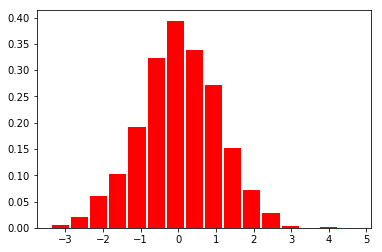

In [81]:
print('Sharpe Ratio rResults (considering entire universe): ')
n, bins, patches = plt.hist(sharpe_results_bollinger_all_a_all, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average result: ', np.mean(sharpe_results_bollinger_all_a_all))

Kalman filter:

In [690]:
entry_multiplier=2
exit_multiplier=0.5

sharpe_results_kalman_all_a_all, cum_returns_kalman_all_all = apply_kalman_strategy(total_pairs_all_a_all,
                                                                                    entry_multiplier,
                                                                                    exit_multiplier)

NameError: name 'apply_kalman_strategy' is not defined

Sharpe Ratio Results (considering the entire universe): 
Average result:  0.2917998463678402


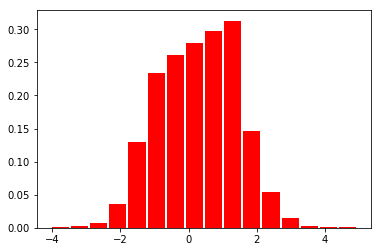

In [84]:
print('Sharpe Ratio Results (considering the entire universe): ')
n, bins, patches = plt.hist(sharpe_results_kalman_all_a_all, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average result: ', np.mean(sharpe_results_kalman_all_a_all))

### Out of Sample Data

Identified pairs under `unique_tickers`

In [ ]:
initial_date = '01-01-2018'
final_date = '01-01-2019'
data_source = 'yahoo'
error_counter = 0
dataset_ofs = {key: None for key in unique_tickers}
for ticker in unique_tickers:
    try:
        df = data.DataReader(ticker, data_source, initial_date, final_date)
        series = df['Adj Close']; series.name = ticker # filter close price only
        dataset_ofs[ticker] = series.copy()
    except:
        error_counter = error_counter + 1
        print('Not Possible to retrieve information for '+ticker)

**Bollinger Bands Out-of-Sample**

In [ ]:
lookback_multiplier=2
sharpe_results_bollinger_ofs = []
returns_bollinger_ofs = []
for pair in total_pairs:
    print('\n\n{},{}'.format(pair[0], pair[1]))
    coint_result = pair[2]
    pnl, ret, summary, sharpe = trader.bollinger_band_strategy(dataset_ofs[coint_result['Y'].name],
                                                               dataset_ofs[coint_result['X'].name], 
                                                               lookback_multiplier*coint_result['half_life'],
                                                               entry_multiplier=2, exit_multiplier=0.5)
    returns_bollinger_ofs.append(ret)
    sharpe_results_bollinger_ofs.append(sharpe)

In [ ]:
print('Sharpe Ratio Results: ')
n, bins, patches = plt.hist(sharpe_results_bollinger_ofs, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average Sharpe Ratio: ', np.mean(sharpe_results_bollinger_ofs))

It performs fairly poorly. Let's see how many of the identified pairs actually turned out to be cointegrated during this period.

### The Correlation Filter

The correlation filter aims to track how the correlation between the two legs of tha pair is varing, and provide that information as input to the trading strategy.

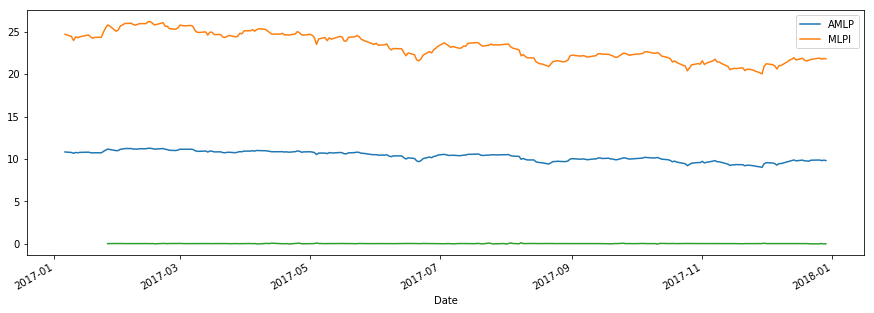

In [466]:
example_pair = failed_pairs[2]

example_pair_leg1 = example_pair[0][0]
example_pair_leg2 = example_pair[0][1]

example_pair_prices = etfs_pricing[[example_pair_leg1, example_pair_leg2]]
example_pair_prices.plot(figsize=(15,5))


# proceed to calculate correlation
rolling_window = config['trading']['lookback_multiplier']*example_pair[0][2]['half_life']

# get returns
example_pair_returns = data_processor.get_return_series(example_pair_prices)

# analyze correlation on returns
example_correlation = example_pair_returns[example_pair_leg1].rolling(rolling_window).corr(example_pair_returns[example_pair_leg2])

# plot correlation of returns
diff_example_correlation = example_correlation.diff(periods=1)
#diff_example_correlation = diff_example_correlation*10
diff_example_correlation.plot()

This result indicates there's almost no correlation between correlation diff and returns... Let's see how this result varies on average:

In [380]:
failure_correlations = []
for failure in failed_pairs:
    failure_df = failure[1][failure[1].units != 0]
    correlation = failure_df['ret'].corr(failure_df['correlation'])
    failure_correlations.append(correlation)
    
print(np.mean(failure_correlations))

-0.04480324434678721


However, we are not realyy interested in the correlation of the the diff column, but rather on the correlation with its sign.

In [376]:
failure_correlations = []
for failure in failed_pairs:
    failure_df = failure[1][failure[1].units != 0]
    failure_df['diff_correlation_sign']=failure_df['diff_correlation'].apply(lambda row: -1 if row<0 else 1)
    correlation = failure_df['ret'].corr(failure_df['diff_correlation_sign'])
    failure_correlations.append(correlation)
    
print(np.mean(failure_correlations))

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.021426798923804273


We could use mutual information rather than correlation as the sign is discrete. What about the relation with the zscore evolution?

### Analyze non-profitable pairs

In [589]:
sharpe_results_bollinger = np.asarray(sharpe_results_bollinger)
negative_pairs_indices = np.argwhere(sharpe_results_bollinger < 0)
print('{} out of {} pairs turned out to be non-profitable'.format(len(negative_pairs_indices), len(total_pairs)))

10 out of 71 pairs turned out to be non-profitable


Let's get some more information on the non-profitable pairs:

In [590]:
negative_pairs = [total_pairs[i] for i in negative_pairs_indices.flatten()]
negative_pairs = [(item[0], item[1]) for item in negative_pairs]
negative_pairs

[('AMJ', 'MLPX'),
 ('AMLP', 'MLPI'),
 ('AMZA', 'ENFR'),
 ('MLPX', 'TPYP'),
 ('DBC', 'FTGC'),
 ('FTGC', 'GSG'),
 ('FTGC', 'PDBC'),
 ('FTGC', 'RJI'),
 ('FIW', 'PHO'),
 ('DBA', 'RJA')]

To what clusters do these pairs belong?

In [591]:
for label_n in range(len(counts)):
    elements_cluster_n = list(clustered_series[clustered_series == label_n].index)
    etfs_cluster_n = etfs_unique[etfs_unique['Ticker'].isin(elements_cluster_n)]
    for pair in negative_pairs:
        if pair[0] in list(etfs_cluster_n.Ticker):
            print('Pair {} belongs to cluster {}'.format(pair, label_n))

Pair ('AMJ', 'MLPX') belongs to cluster 0
Pair ('AMLP', 'MLPI') belongs to cluster 0
Pair ('AMZA', 'ENFR') belongs to cluster 0
Pair ('MLPX', 'TPYP') belongs to cluster 0
Pair ('DBC', 'FTGC') belongs to cluster 1
Pair ('FTGC', 'GSG') belongs to cluster 1
Pair ('FTGC', 'PDBC') belongs to cluster 1
Pair ('FTGC', 'RJI') belongs to cluster 1
Pair ('FIW', 'PHO') belongs to cluster 3
Pair ('DBA', 'RJA') belongs to cluster 4


How do the statistics rank?

In [623]:
sorted_indices = np.flip(np.argsort(sharpe_results_bollinger), axis=0)

# initialize list of lists 
data = []
for index in sorted_indices:
    # get number of positive and negative positions
    position_returns = performance[index][1].position_return
    positive_positions = len(position_returns[position_returns>0])
    negative_positions = len(position_returns[position_returns<0])
    data.append([total_pairs[index][0],
                 total_pairs[index][1],
                 total_pairs[index][2]['t_statistic'],
                 total_pairs[index][2]['p_value'],
                 total_pairs[index][2]['zero_cross'],
                 total_pairs[index][2]['half_life'],
                 total_pairs[index][2]['hurst_exponent'],
                 positive_positions,
                 negative_positions,
                 sharpe_results_bollinger[index]
                ])
      
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['Leg1', 'Leg2', 't_statistic', 'p_value', 'zero_cross',
                                   'half_life', 'hurst_exponent', 'positive trades', 'negative_trades',
                                   'sharpe_result']) 
df

,Leg1,Leg2,t_statistic,p_value,zero_cross,half_life,hurst_exponent,positive trades,negative_trades,sharpe_result
0,EMLP,MLPI,-4.119981,0.000897,34,5,0.117162,19,9,2.425467
1,PXE,XLE,-2.944452,0.040418,21,11,0.132905,9,2,2.404698
2,AMJ,AMZA,-2.998947,0.034993,24,10,0.175520,9,4,2.010823
3,EMLP,YMLI,-4.061982,0.001119,28,5,0.113669,17,10,1.879715
4,EMLP,IMLP,-4.083088,0.001033,28,5,0.115862,20,9,1.857711
5,MLPI,TPYP,-3.730445,0.003705,36,6,0.152077,14,4,1.837709
6,EMLP,MLPX,-3.912173,0.001947,25,6,0.098952,14,7,1.813720
7,TPYP,YMLI,-3.796505,0.002943,28,6,0.138340,15,6,1.746730
8,AMLP,EMLP,-4.107690,0.000941,34,5,0.119430,20,7,1.743644
9,AMJ,TPYP,-3.755516,0.003397,38,6,0.151137,13,7,1.718024


In [593]:
# analyze correlations
print('Half-life vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['half_life']))
print('Zero crossings vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['zero_cross']))
print('p-value vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['p_value']))
print('t-statistic vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['t_statistic']))
print('Hurst exponent vs Sharpe Ratio correlation ', df['sharpe_result'].corr(df['hurst_exponent']))

Half-life vs Sharpe Ratio correlation:  -0.32182336045579807
Zero crossings vs Sharpe Ratio correlation:  -0.11839381958282873
p-value vs Sharpe Ratio correlation:  -0.3650197578162554
t-statistic vs Sharpe Ratio correlation:  -0.40421527393166984
Hurst exponent vs Sharpe Ration correlation  -0.34804930252364047


Are there any signs these pairs were not profitable as the strategy evolves? Could we have predicted their lack of profitability?
- Using a ML algorithm that recognizes when a pair is not profitable anymore.
- Checking how the hurst exponent has been changing.
- Analyze their previous positions' returns

In [37]:
performance_bollinger[0][1][36:]

,pnl,ret,spread,AMZA,AMJ,zscore,current_position,position_return
Date,,,,,,,,
2017-03-01,0.000000,0.000000,1.483112,7.388008,28.788561,NaN,0.0,0.000000
2017-03-02,0.000000,0.000000,2.331933,7.401095,28.710335,NaN,0.0,0.000000
2017-03-03,0.000000,0.000000,2.628563,7.401095,28.684263,NaN,0.0,0.000000
2017-03-06,0.000000,0.000000,2.796648,7.414185,28.719028,0.891900,0.0,0.000000
2017-03-07,0.000000,0.000000,2.969386,7.394551,28.614721,1.028821,0.0,0.000000
2017-03-08,0.029830,0.002524,3.058205,7.280036,28.067114,1.081804,-1.0,0.000000
2017-03-09,0.013779,0.001198,3.075901,7.230956,27.832424,1.070933,-1.0,0.000000
2017-03-10,0.015062,0.001323,2.938429,7.214596,27.823729,0.953145,-1.0,0.000000
2017-03-13,-0.012352,-0.001075,2.819490,7.230956,27.849806,0.846794,-1.0,0.000000
